# Data Aggregation and Analysis Replication Code

This is the code that replicates our analytical workflow for identifying and interpreting digital formation processes of Craigslist "Free Stuff"/"Curb Alert" posts based on the data we collected (using the High Frequency Archaeological Survey approach detailed in the [`collection`](../collection/) directory of this replication materials repository) and then preprocessed in [`00_preprocessing.ipynb`](./00_preprocessing.ipynb). We also write aggregate data (compiled in this notebook) to file so that other researchers can replicate the figures in the article body (using the code in [`02_visualization.ipynb`](./02_visualization.ipynb)), while still preserving the privacy of Craigslist users by not publishing individual post data (which often includes home addresses in the body text, alongside exact longitude/latitude coordinates).

Note that this code is intended to be run on an AWS EMR cluster using a PySpark kernel, which can be done via a "Workspace" in AWS [EMR Studio](https://docs.aws.amazon.com/emr/latest/ManagementGuide/emr-studio.html). The following has been tested on an EMR cluster (1 primary node, 6 core nodes -- all m5.xlarge EC2 instances) using EMR release label 6.2.0 with Hadoop (3.2.1), Hive (3.1.2), JupyterEnterpriseGateway (2.1.0), Livy (0.7.0), and Spark (3.0.1) installed. For detailed instructions on how to launch and configure an equivalent cluster, consult [the AWS EMR documentation](https://docs.aws.amazon.com/emr/latest/ReleaseGuide/emr-configure-apps-create-cluster.html?icmpid=docs_emr_help_panel
).

## Installing packages and configuring Spark

Once we have launched our Spark cluster and are running this notebook using a PySpark kernel, we can then configure our Spark environment (here adjusting some settings to allow us to install additional Python packages, as well as support Spark NLP) and install additional Python packages that we will need to use in this notebook.

In [ ]:
%%configure -f
{
    "conf": {
        "spark.jars.packages": "com.johnsnowlabs.nlp:spark-nlp_2.12:4.3.1",
        "spark.kryoserializer.buffer.max":"2000M",
        "spark.serializer":"org.apache.spark.serializer.KryoSerializer",
        "spark.yarn.preserve.staging.files":"true",
        "spark.yarn.stagingDir":"hdfs:///tmp",
        "spark.driver.memory":"12000M",
        "spark.driver.maxResultSize":"0",
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

In [ ]:
# install relevant packages in EMR environment
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("scipy==1.7.0")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.1")
sc.install_pypi_package("lifelines==0.27.4")
sc.install_pypi_package("spark-nlp==4.4.4")
sc.install_pypi_package("boto3==1.19.2")

## Loading data and importing packages

We are now ready to load in the data collected in February 2023, import packages, and instantiate relevant objects that we will be using throughout the notebook. Note that all of the `VBox` and `FloatProgress` output beneath cells is an artifact of running the code on an EMR cluster using Spark (which enables a progress bar and indication of task completion that are no longer visible outside the EMR envronment).

In [3]:
import matplotlib.pyplot as plt 
from pyspark.sql.window import Window
import pyspark.sql.functions as F
import pyspark.sql.types as T
import sparknlp
from sparknlp.base import DocumentAssembler, Finisher, EmbeddingsFinisher, LightPipeline
from sparknlp.annotator import RegexTokenizer, Normalizer, LemmatizerModel, StopWordsCleaner, WordEmbeddingsModel, SentenceEmbeddings, SentenceDetector
from pyspark.ml import Pipeline
from pyspark.ml.feature import SQLTransformer
import numpy as np
import pandas as pd
from itertools import combinations
from scipy.spatial.distance import cosine
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
from lifelines.utils import median_survival_times
from lifelines.statistics import pairwise_logrank_test
import json
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
import boto3

def plot_histogram_data(data):
    # plots histogram based on output of Spark RDD `histogram` method
    # for exploratory analysis
    binSides, binCounts = data
    binSides = [round(b, 2) for b in binSides]
    N = len(binCounts)
    ind = np.arange(N)
    width = 1

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    rects1 = ax.bar(ind + 0.5, binCounts, width, color='b')

    ax.set_ylabel('Frequencies')
    ax.set_title('Histogram')
    ax.set_xticks(np.arange(N + 1))
    ax.set_xticklabels(binSides, rotation=90)

    plt.show()

# Create an empty dictionary to store aggregate data to be plotted in 02_visualization.ipynb
# also instantiate S3 client for persisting data as JSON
to_plot = {}
s3_client = boto3.client('s3')

# load in preprocessed parquet data produced in `00_preprocessing.ipynb`
data = spark.read.parquet('s3://craigslist-post-data/02_2023/*.parquet').persist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# take a look to make sure data/types look right
data.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- city: string (nullable = true)
 |-- category: string (nullable = true)
 |-- post_id: string (nullable = true)
 |-- time_posted: timestamp (nullable = true)
 |-- last_updated: timestamp (nullable = true)
 |-- time_downloaded: timestamp (nullable = true)
 |-- title: string (nullable = true)
 |-- body_text: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- image_s3_keys: array (nullable = true)
 |    |-- element: string (containsNull = true)

## Erasures

The first question to investigate is: **How many erasures are there and at what rate are posts erased?**

To answer this question, let's first separate the posts that have been erased from those that are still around at the end of the study period.

In [5]:
# Compute overall average number of hours that posts are active on the platform (~X hours)
hours_active_by_id = data.groupBy('post_id') \
                         .count() \
                         .withColumnRenamed("count", "hours_active")

# Restrict analysis to posts that were actually posted on first day of collection or later
first_day_or_later = (data["time_posted"] >= '2023-02-01')

# and were (not) removed by end of collection period (studying erasures v. non-erasures)
list_remaining = data[data["time_downloaded"] >=  '2023-02-28 23:00:00'].rdd.map(lambda x: x['post_id']) \
                                                                            .collect()
never_removed = (data.post_id.isin(list_remaining))

# filter data by start date and removal status
erasures = data[first_day_or_later & ~never_removed]
not_erased = data[first_day_or_later & never_removed]
overall = data[first_day_or_later]

# Join back to full dataset and drop duplicates for now
# (only interested in looking at relationship between count and static features;
# we'll look at edits later)
erasure_df = hours_active_by_id.join(erasures,
                                     on='post_id') \
                               .dropDuplicates(['post_id']) \
                               .persist()
non_erasure_df = hours_active_by_id.join(not_erased,
                                         on='post_id') \
                                   .dropDuplicates(['post_id']) \
                                   .persist()
overall_df = hours_active_by_id.join(overall,
                                     on='post_id') \
                               .dropDuplicates(['post_id']) \
                               .persist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Percent Erased Overall

First, looking at posts that have been erased during the study period to study how many posts are erased over the course of the month, we can see that ***over 74% of all the collected posts were erased***.

In [6]:
n_erasures = erasure_df.count()
n_non_erasures = non_erasure_df.count()
n_erasures / overall_df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.7418971844450613

This seems in line with expectations from previous months as well -- the oldest posts that were collected during the study period were from November 2022 (and there were only 47 of them left when we started collecting in February!):

In [7]:
data.dropDuplicates(['post_id']) \
    .groupby(F.month('time_posted').alias('month'),
             F.year('time_posted').alias('year')) \
    .agg(F.count('post_id').alias('total_count')) \
    .filter("month != '2'") \
    .sort(['year', 'month']) \
    .show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+----+-----------+
|month|year|total_count|
+-----+----+-----------+
|   11|2022|         47|
|   12|2022|       2548|
|    1|2023|      20279|
+-----+----+-----------+

This is an imperfect geographic sample as well -- missing any posts from top posting cities like San Francisco, while featuring 11 posts from Minneapolis (which posted only around 15% of the number of overall posts as San Francisco in our February study period).

In [8]:
data.dropDuplicates(['post_id']) \
    .withColumn('month', F.month('time_posted')) \
    .filter("month == '11'") \
    .groupby('city') \
    .count() \
    .sort('count', ascending=False) \
    .show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+-----+
|        city|count|
+------------+-----+
| minneapolis|   11|
|      denver|    7|
|orangecounty|    6|
|     atlanta|    5|
|     phoenix|    4|
|philadelphia|    3|
|      dallas|    3|
|     houston|    2|
|       miami|    2|
|     detroit|    2|
|      austin|    1|
|     raleigh|    1|
+------------+-----+

### Hours-to-erasure overall

Of those posts that are erased, ***50% of the posts are gone in 18 hours or less*** (and ***25% are removed in 3 hours or less***). Almost all erasures (75% -- at the top of the IQR) are made within two days. 

Overall, it appears that even the digital indices of the "Curb Alert" landscape are highly ephemeral and erasures occur often and quickly. Note that the distribution peaks at under 24 hours, and seems to follow an exponential decay pattern (i.e. the distribution has a really long tail -- it's improbable that a post will stick around much longer than where the bulk of the distribution is). This seems to indicate the importance of employing high-frequency survey methods. If we collected data on a daily basis (or even worse, a weekly or monthly basis!), our data would be highly biased and we would not capture most of the data.

In [9]:
# Show overall summary statistics
erasure_df[['hours_active']].summary().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+
|summary|      hours_active|
+-------+------------------+
|  count|             48115|
|   mean|44.673573729606154|
| stddev| 75.60712643690852|
|    min|                 1|
|    25%|                 3|
|    50%|                18|
|    75%|                48|
|    max|               657|
+-------+------------------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

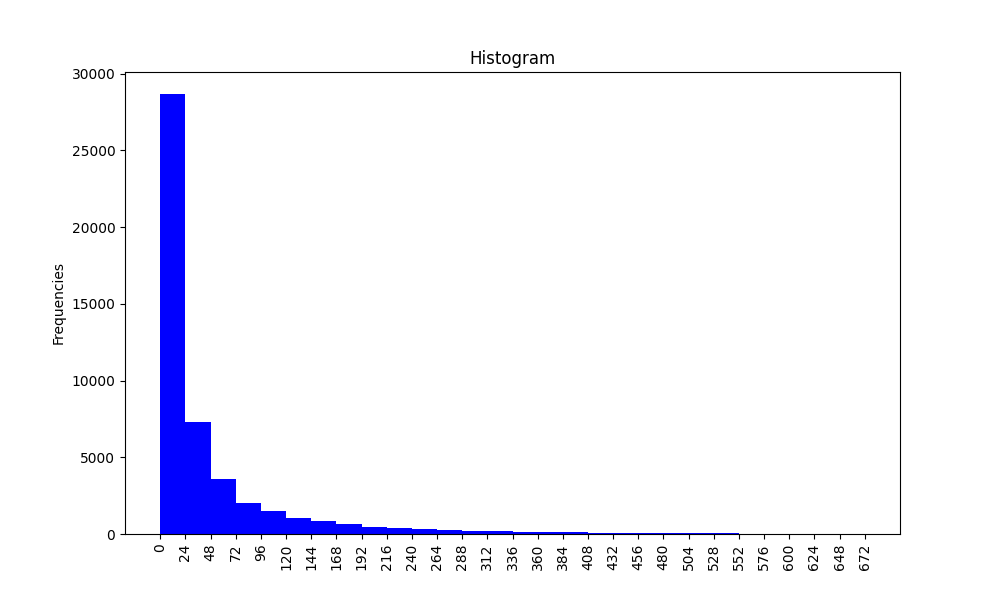

In [10]:
# Plot as histogram; daily
plt.close()
daily_bin_boundaries = [i for i in range(0, 28 * 24 + 1, 24)]
erasure_hist_bins = erasure_df.select('hours_active') \
                              .rdd.flatMap(lambda x: x) \
                              .histogram(daily_bin_boundaries)
plot_histogram_data(erasure_hist_bins)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

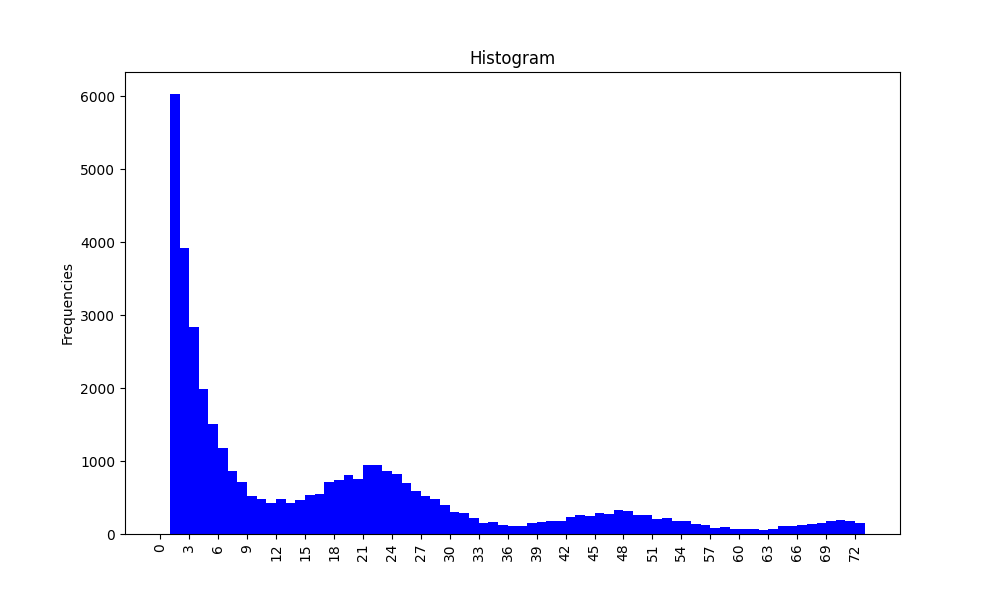

In [11]:
# Plot as histogram; hourly -- note that within the day there is variation as well in erasure status
# some hourly seasonality -- second peak ~24 hours after posting, third smaller peak peak ~48 hours after posting, etc.
plt.close()
hourly_bin_boundaries = [i for i in range(0, 28 * 24 + 1)]
erasure_hist_bins = erasure_df.select('hours_active') \
                              .rdd.flatMap(lambda x: x) \
                              .histogram(hourly_bin_boundaries)

# export for plotting outside of PySpark environment
to_plot['fig3'] = erasure_hist_bins

plot_histogram_data((erasure_hist_bins[0][:(3 * 24 + 1)], erasure_hist_bins[1][:(3 * 24 + 1)]))
plt.xticks(np.arange(0, 3 * 24 + 1, 3), labels=np.arange(0, 3 * 24 + 1, 3))
%matplot plt

This hours-to-erasure data is a good candidate for modeling via Kaplan-Meier Survival Curves (modeling the probability that a post will remain "alive" for each number of hours), and we can see that the probability of a post remaining active for more than 100 hours is diminishingly small:

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

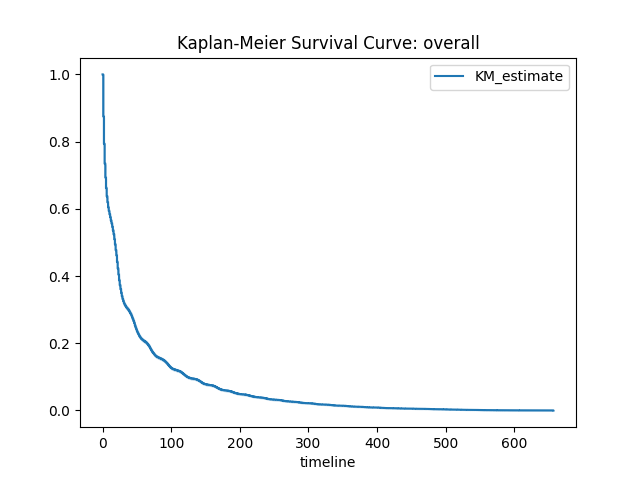

In [12]:
durations_overall = np.repeat(erasure_hist_bins[0][:-1], erasure_hist_bins[1])
kmf.fit(durations_overall)

plt.close()
kmf.plot(title='Kaplan-Meier Survival Curve: {}'.format('overall'))
%matplot plt

### End-of-month palimpsest

How about posts that were never erased? This is most interesting for identifying the number of posts that would still exist from a reference period. For instance, **how many posts would still be around from time `t` in the last month if we collected data on March 1st at midnight?**

What we actually see at any given moment is a palimpsest (most of which has been erased -- and predominantly within the first day of it being posted). The bulk of the distribution is set around the past week, though -- definitely a **recency bias** as we might expect. Interestingly, though, our palimpsest seems to be conditioned by a certain seasonality (rising and falling in frequency throughout the study period). If you count backwards, you can see that these are **heavily centered around weekends**.

In [13]:
# Show overall summary statistics
non_erasure_df[['hours_active']].summary().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+
|summary|     hours_active|
+-------+-----------------+
|  count|            16739|
|   mean|262.5653862237888|
| stddev|192.9406789124774|
|    min|                1|
|    25%|               79|
|    50%|              672|
|    75%|              413|
|    max|              672|
+-------+-----------------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

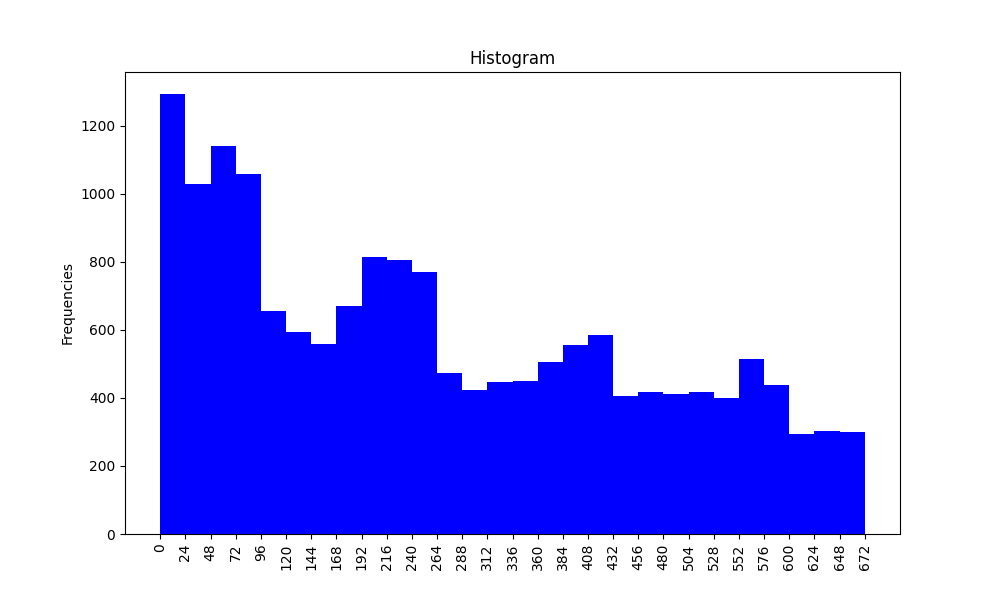

In [14]:
# Plot histogram
plt.close()
non_erasure_hist_bins = non_erasure_df.select('hours_active') \
                                      .rdd.flatMap(lambda x: x) \
                                      .histogram(daily_bin_boundaries)
# export for plotting outside of PySpark environment
to_plot['fig4_l'] = non_erasure_hist_bins

plot_histogram_data(non_erasure_hist_bins)
%matplot plt

Is this seasonality just a function of there being more posts overall on weekends? We can check and see that there are indeed more posts over the weekends and consider the percent share of posts that are erased by day in our analysis. It looks like there are quite a bit more new posts on weekends (Feb. 4/5, 11/12, 18/19/20, and 25/26) and the overall curve of posts still remains roughly exponential.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

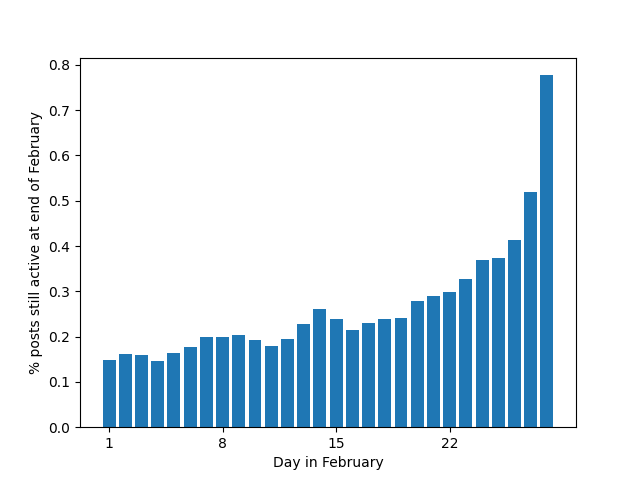

In [15]:
overall_posts_by_day_reversed = overall_df.withColumn("day_posted", F.dayofmonth('time_posted')) \
                                          .groupBy('day_posted') \
                                          .count() \
                                          .orderBy('day_posted', ascending=False) \
                                          .rdd.map(lambda x: x['count']) \
                                          .collect()

# export for plotting outside of PySpark environment
to_plot['fig4_r'] = overall_posts_by_day_reversed

plt.close()
plt.bar(list(range(28, 0, -1)), [non_erasure_hist_bins[1][i] / overall_posts_by_day_reversed[i] for i in range(28)])
plt.xlabel('Day in February')
plt.xticks(list(range(1, 29, 7)))
plt.ylabel('% posts still active at end of February')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

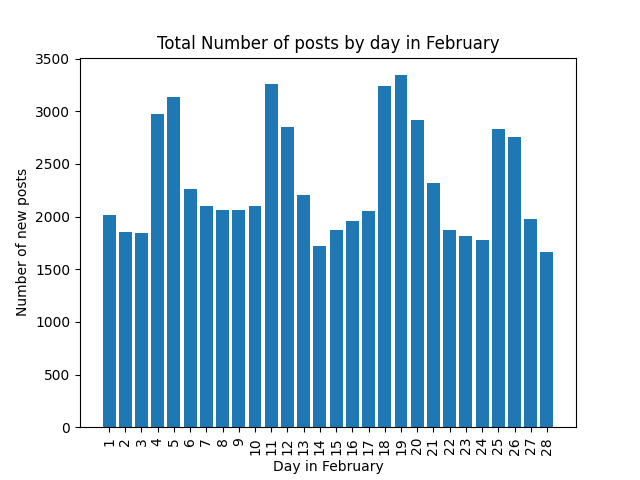

In [16]:
plt.close()
plt.bar(list(range(1,29)), overall_posts_by_day_reversed[::-1])
plt.title('Total Number of posts by day in February')
plt.ylabel('Number of new posts')
plt.xticks(list(range(1, 29)), rotation=90)
plt.xlabel('Day in February')
%matplot plt

**What influences these erasures?** Are they from particular places? List objects with particular material characteristics?

### Percent Erased by city

First, notice that not all cities post to the same degree -- some have considerably more posts in a month (e.g. SF had over 1m unique posts). Also note that some cities have considerably different erasure/non-erasure ratios (i.e. Houston, Dallas, and Las Vegas, where over 80% of all posts were erased -- far higher than the overall average; or, consider Boston and Philadelphia where only 68% and 69% of posts were erased by the end of the study period -- ~5-6% less than the overall stats quoted earlier). We thus have geographically distinct erasure patterns in volume and velocity of posting and erasures that will influence interpretations of the collections (we can see even further when we look at more aggregated, regional survival curves).

In [17]:
pct_erased_by_city = overall_df.groupby('city') \
                               .agg(F.count('hours_active').alias('total_count'), 
                                    F.mean('longitude').alias('longitude'),
                                    F.mean('latitude').alias('latitude')) \
                               .join(erasure_df.groupby('city') \
                                               .agg(F.count('hours_active').alias('erasure_count')),
                                                    on='city') \
                               .withColumn('pct_erased',
                                           (F.col('erasure_count') / F.col('total_count'))) \
                               .sort('pct_erased')
pct_erased_by_city.show(23)

# export for plotting outside of PySpark environment
to_plot['fig2'] = pct_erased_by_city.toPandas().to_dict()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+-----------+-------------------+------------------+-------------+------------------+
|        city|total_count|          longitude|          latitude|erasure_count|        pct_erased|
+------------+-----------+-------------------+------------------+-------------+------------------+
|      boston|       2987| -71.14564150133963| 42.39646401942397|         2020|0.6762638098426514|
|philadelphia|       1163| -75.23480068959586|40.045263395528806|          798|0.6861564918314703|
|     chicago|       1381| -87.83362113178858|41.924849154960164|          973|0.7045619116582187|
|washingtondc|       3524| -77.18256491118046|38.915438168274704|         2497|0.7085698070374574|
|     seattle|       5063|-122.32281396958327|  47.5818112141023|         3596|0.7102508394232668|
|       sfbay|      14938|-122.24621108963717|37.710492458227336|        10856|0.7267371803454278|
|  losangeles|       4342|-118.31126221142333| 34.07611118562876|         3183|0.7330723169046522|
|     newy

### Hours-to-erasure by city

In [18]:
hours_to_erasure_by_city = erasure_df.groupBy('city') \
                                     .agg(F.count('hours_active').alias('count'),
                                          F.mean('longitude').alias('longitude'),
                                          F.mean('latitude').alias('latitude'),
                                          F.mean('hours_active').alias('mean'),
                                          F.stddev('hours_active').alias('std'),
                                          F.min('hours_active').alias('min'),
                                          F.expr('percentile(hours_active, array(0.25))')[0].alias('%25'),
                                          F.expr('percentile(hours_active, array(0.5))')[0].alias('%50'),
                                          F.expr('percentile(hours_active, array(0.75))')[0].alias('%75'),
                                          F.max('hours_active').alias('max')) \
                                     .orderBy('%25', '%50', '%75', 'max')
hours_to_erasure_by_city.show(23)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+-----+-------------------+------------------+------------------+------------------+---+---+----+-----+---+
|        city|count|          longitude|          latitude|              mean|               std|min|%25| %50|  %75|max|
+------------+-----+-------------------+------------------+------------------+------------------+---+---+----+-----+---+
|    lasvegas|  486|-115.15438906995884| 36.17318571604938| 32.55555555555556|  61.0874647576364|  1|2.0| 7.0| 29.0|430|
|      dallas|  912| -96.93317837102093| 32.91170714050493| 30.38048245614035| 54.80712586562652|  1|2.0|10.0|29.25|507|
|       miami|  586| -80.20213779863484|26.142082501706486|37.008532423208194| 67.09896960419812|  1|2.0|10.0| 42.0|571|
|     houston|  665|  -95.4619626300752|29.818060270676693|37.169924812030075| 68.47715077643196|  1|2.0|11.0| 33.0|422|
|orangecounty| 1890|-117.82408393068773|33.712129485185166| 38.69100529100529| 69.29427029531112|  1|2.0|14.0| 40.0|582|
|     phoenix| 1166|-111.9725182

### Regional Variation in post survival

In [19]:
cities = data[['city']].distinct() \
                       .rdd.map(lambda x: x['city']) \
                       .collect()

# Generate arrays of post survival durations (in hours) by city
durations_by_city = {}
for c in cities:
    hist_bins = erasure_df[erasure_df['city'] == c].select('hours_active') \
                                                   .rdd.flatMap(lambda x: x) \
                                                   .histogram(hourly_bin_boundaries)
    
    durations_by_city[c] = np.repeat(hist_bins[0][:-1], hist_bins[1])

# concatenate city durations by region
regions = {
    'northeast': ['boston', 'newyork', 'philadelphia', 'washingtondc'],
    'south': ['atlanta', 'austin', 'dallas', 'houston', 'miami', 'raleigh'],
    'midwest': ['chicago', 'detroit', 'minneapolis'],
    'west': ['denver', 'lasvegas', 'losangeles', 'orangecounty', 'phoenix', 'portland', 'sacramento', 'sandiego', 'seattle', 'sfbay']
}

durations_by_region = {r: pd.DataFrame({'duration': np.concatenate([durations_by_city[i] for i in c]),
                                        'region': r})
                       for r, c in regions.items()}

pdf_duration_region = pd.concat(durations_by_region.values())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
log_rank = pairwise_logrank_test(pdf_duration_region['duration'], pdf_duration_region['region'])
log_rank.summary

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                     test_statistic             p   -log2(p)
midwest   northeast        2.475253  1.156508e-01   3.112153
          south           36.857978  1.270551e-09  29.551898
          west             0.302570  5.822755e-01   0.780226
northeast south           94.162587  2.906426e-22  71.543172
          west            11.708427  6.221768e-04  10.650388
south     west            73.448586  1.032919e-17  56.426050

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

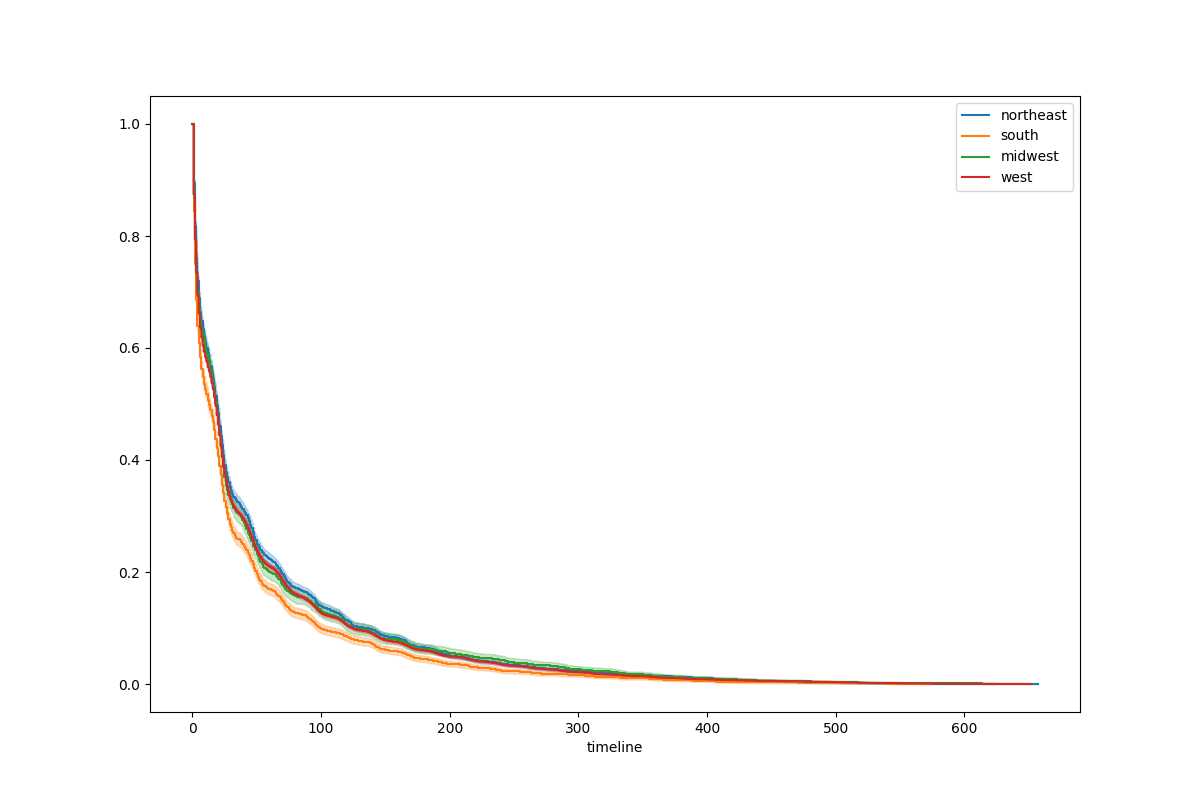

In [21]:
plt.close()
fig, ax = plt.subplots(figsize=(12, 8))
for r, df in durations_by_region.items():
    kmf.fit(df['duration'], label=r)
    kmf.plot(ax=ax)

%matplot plt

Although not discussed in the article, the survival curves for individual cities map on fairly consistently with their regional designations, which we can also see by plotting their survival curves or performing pairwise logrank tests as above.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

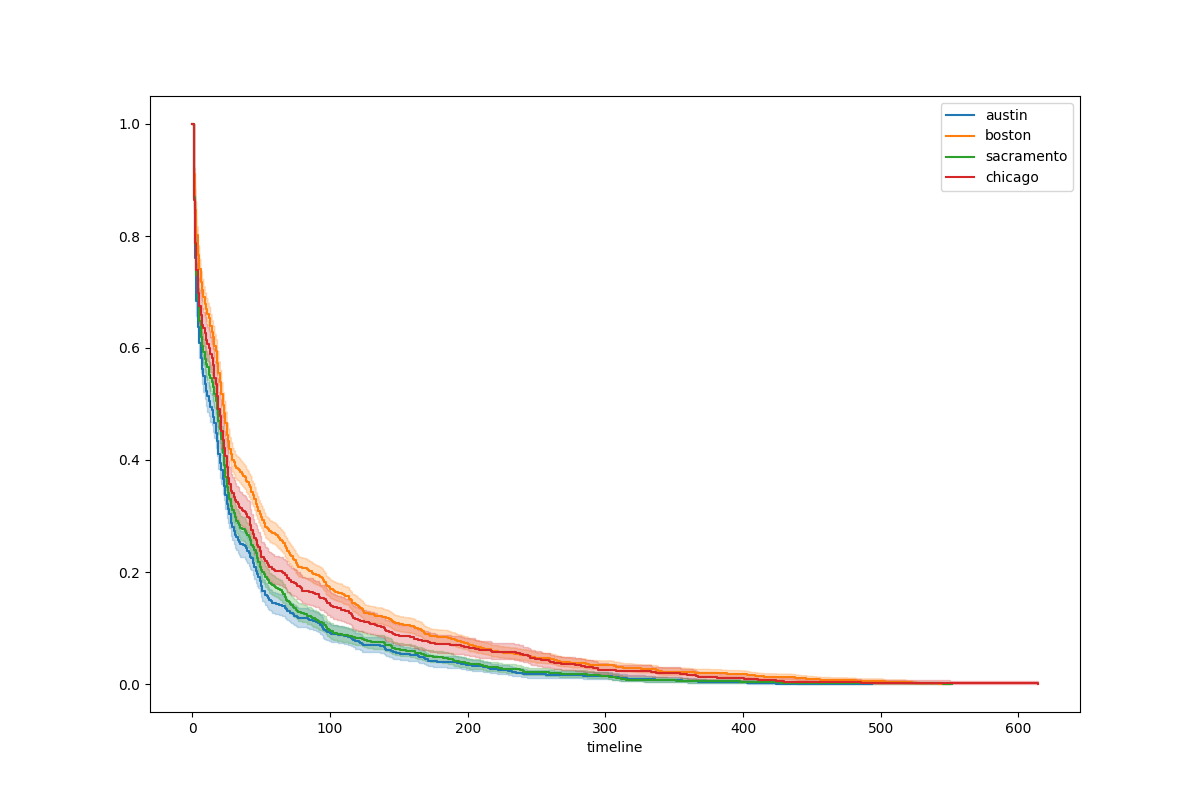

In [23]:
plt.close()
fig, ax = plt.subplots(figsize=(12, 8)) 
for c, d in durations_by_city.items():
    if c in {'chicago', 'austin', 'boston', 'sacramento'}:
        kmf.fit(d, label=c)
        kmf.plot(ax=ax)
%matplot plt

### End-of-month palimpsest by city

These differing survival curves produce different end-of-month palimpsests in each city. Although their IQRs overlap, the median time-to-erasure is quite different between cities (especially those at the extremes i.e. Dallas and Sacramento, for instance)

In [24]:
non_erasure_df.groupBy('city') \
              .agg(F.count('hours_active').alias('count'),
                   F.mean('hours_active').alias('mean'),
                   F.stddev('hours_active').alias('std'),
                   F.min('hours_active').alias('min'),
                   F.expr('percentile(hours_active, array(0.25))')[0].alias('%25'),
                   F.expr('percentile(hours_active, array(0.5))')[0].alias('%50'),
                   F.expr('percentile(hours_active, array(0.75))')[0].alias('%75'),
                   F.max('hours_active').alias('max')) \
              .orderBy('%25', '%50', '%75') \
              .show(23)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+-----+------------------+------------------+---+------+-----+------+---+
|        city|count|              mean|               std|min|   %25|  %50|   %75|max|
+------------+-----+------------------+------------------+---+------+-----+------+---+
|      dallas|  225|216.72444444444446|185.07822809793979|  1|  51.0|169.0| 361.0|666|
|     atlanta|  267|233.63295880149812|193.87221617051458|  1|  52.5|193.0| 390.5|651|
|     raleigh|  245|248.64897959183673| 208.5344038550177|  1|  56.0|177.0| 432.0|658|
|philadelphia|  365|242.46027397260275|200.62560584258662|  1|  57.0|197.0| 408.0|668|
|      denver|  711|247.56258790436004|203.22302660384162|  1|  68.5|197.0| 411.5|670|
|     houston|  141| 218.8368794326241| 174.9355646318085|  1|  70.0|173.0| 366.0|625|
|orangecounty|  576|244.97222222222223|192.42562224563122|  1|  71.0|215.0| 411.0|651|
|     seattle| 1467|257.64008179959103| 197.1251047751124|  1|  75.0|216.0| 412.0|670|
|     phoenix|  293|248.37883959044368|198.

### City-level palimpsest cosine distance comparisons

Let's take a closer look at each city's non-erasure histograms to see if we can identify any more nuanced divergences that are masked by the aggregate-level statistics above. We'll also measure the cosine distance from each city's histogram at the end of the month to other cities and see if there are any major divergences in histogram shape (think about this in the same way as correlation, where 0 is identical and 1 is completely uncorrelated). While we can employ survival analysis techniques (as we did above) to study regional erasure patterns, this will particularly help us to understand how the palimpsests we see in different cities compare to one another (beyond the summary statistics above alone).

In [25]:
cities = data[['city']].distinct() \
                       .rdd.map(lambda x: x['city']) \
                       .collect()

# Generate histograms of hours that posts are active by city (binned by day to facilitate inter-city comparison)
hist_by_city = {}
for c in cities:
    erasure_hist_bins = erasure_df[erasure_df['city'] == c].select('hours_active') \
                                                           .rdd.flatMap(lambda x: x) \
                                                           .histogram(daily_bin_boundaries)
    non_erasure_hist_bins = non_erasure_df[non_erasure_df['city'] == c].select('hours_active') \
                                                                       .rdd.flatMap(lambda x: x) \
                                                                       .histogram(daily_bin_boundaries)

    hist_bins = {'erasure': erasure_hist_bins, 
                 'non_erasure': non_erasure_hist_bins}
    hist_by_city[c] = hist_bins

# once we have generated erasure/non-erasure histogram data, compare each combination of cities
combs = combinations(cities, 2)
n_combs = 0
cos_distance = {}
for c1, c2 in combs:
    # Measure cosine distance between each pair of city histograms
    erasure_cos = cosine(hist_by_city[c1]['erasure'][1], hist_by_city[c2]['erasure'][1])
    non_erasure_cos = cosine(hist_by_city[c1]['non_erasure'][1], hist_by_city[c2]['non_erasure'][1])

    cos_distance['{}_{}'.format(c1, c2)] = {'erasure': erasure_cos,
                                            'non_erasure': non_erasure_cos}

    n_combs += 1

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The distance between non-erasure histograms is small (and average distance of 0.083), but we can see there are slight differences between the number of surviving posts from each day across cities.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

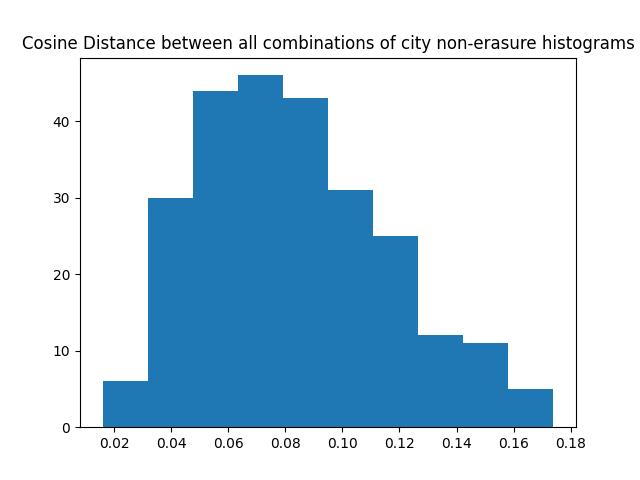

In [28]:
plt.close()
plt.subplots(1,1)
# np.mean([v['non_erasure'] for k,v in cos_distance.items()]) # 0.083
plt.hist([v['non_erasure'] for k,v in cos_distance.items()])
plt.title('Cosine Distance between all combinations of city non-erasure histograms')
%matplot plt

If we take a look at the histograms with the least agreement, we can see that these differences are mostly between cities that exhibit a "weekend effect" (i.e. more posts surviving on weekend days) and those who do not. If we identify the city combinations that have the greatest histogram differences, we can also see that 5 out of 7 cities come from particularly extreme erasure/non-erasure overall percentages. Sacramento, Dallas, and Las Vegas, for instance, are all in the top five cities in terms of the percentage of posts that have been deleted by the end of the study period. Boston and Philadelphia are in the top 5 cities in the percentage of overall posts that survive through the study period.

Particularly in Dallas and Las Vegas, this gives us very little data at the end of the month and relatively unclear distributional patterns as a result. In Sacramento, there is an exceptionally strong weekend effect that results from the erasure processes -- exaggerating the influence of these days in the overall distribution. Meanwhile, Boston seems to only exhibit a partial weekend effect from Presidents Day onward.

Raleigh and Portland are in the middle of the cities in terms of erasure, but Raleigh has an unclear weekend effect and Portland has an especially exaggerated one. All of this is to say that the end-of-month palimpsest of posts likely varies based on city-specific erasure processes.

In [29]:
# identify cities with the biggest differences
ul_ci = round(len([(v['non_erasure'], k) for k,v in cos_distance.items()]) *.025)
sorted([(v['non_erasure'], k) for k,v in cos_distance.items()], reverse=True)[:ul_ci]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(0.17399774857738948, 'sacramento_raleigh'), (0.16461594509218413, 'boston_raleigh'), (0.16249316069360387, 'portland_lasvegas'), (0.1607239747668272, 'sacramento_dallas'), (0.1590561711765931, 'philadelphia_sacramento'), (0.15526927363517118, 'dallas_lasvegas')]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

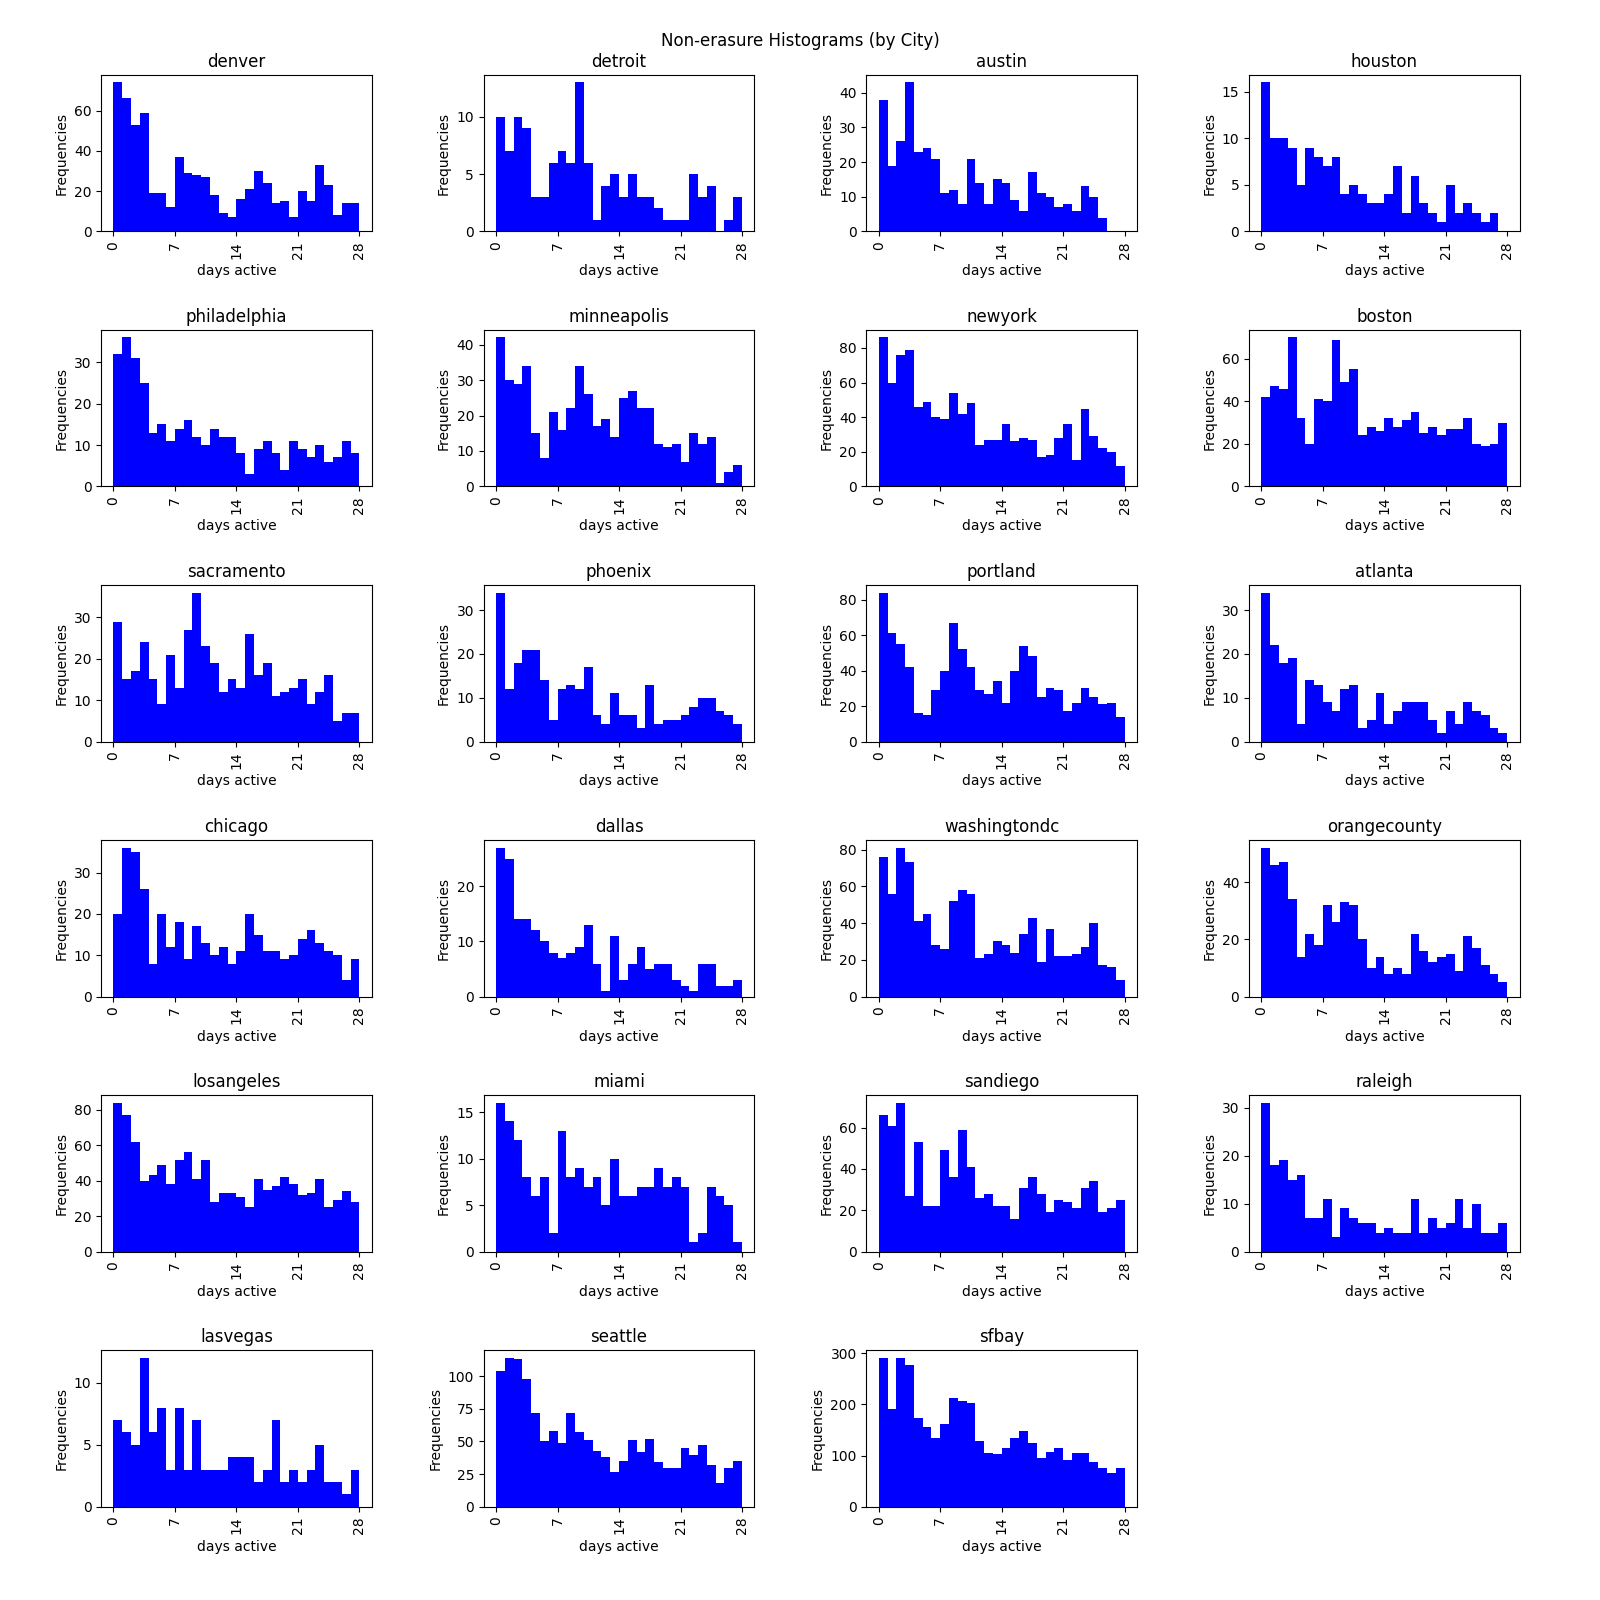

In [30]:
plt.close()
fig, axes = plt.subplots(6, 4, figsize=(16, 16))
fig.tight_layout(pad=5.0)
fig.suptitle('Non-erasure Histograms (by City)')
cities_reshape = np.reshape(cities + ['none'], (6, 4))
for i in range(6):
    for j in range(4):
        city = cities_reshape[i, j]
        ax = axes[i][j]

        if city == 'none':
            ax.axis('off')
            break

        binSides, binCounts = hist_by_city[city]['non_erasure']
        binSides = [round(b, 2) for b in binSides]
        N = len(binCounts)
        ind = np.arange(N)
        width = 1
        
        rects1 = ax.bar(ind + 0.5, binCounts, width, color='b')

        ax.set_ylabel('Frequencies')
        ax.set_title(city)
        ax.set_xticks(np.arange(N + 1, step=7))
        ax.set_xticklabels(np.arange(N + 1, step=7), rotation=90)
        ax.set_xlabel('days active')
%matplot plt

## Identifying post survival patterns based on the material characteristics of objects listed

To identify post content and see if there were any differences in post survival by the material characteristics of objects listed, we used a zero shot classification approach (i.e. how close are the words in a post to pre-trained GloVe embeddings).

In [31]:
# study-specific stop words
extra_stopwords =  ['free', 'inch', 'x', 'use', 'new', 'old',
                    'come', 'good', 'great', 'need', 'pick',
                    'pickup', 'please', 'condition', 'first',
                    'go', 'give', 'take', 'item', 'curb', 'move',
                    'today', 'like', 'stuff', 'asap', 'want',
                    'text', 'email', 'call', 'show', 'contact', 'info'] 

eng_stopwords = stopwords.words('english') + extra_stopwords

# concatenate title and body text (not all posts will reiterate what they are
# posting about after writing the title) and also drop anything that is in
# parentheses at the end (this is posted by Craigslist and lists the city name)
text = overall_df.select('post_id',
                         F.concat_ws(' ', F.regexp_extract(F.col('title'), r'(.*)\(.*\)$', 1),
                                     F.col('body_text')).alias('all_text')) \
                 .filter(F.col('all_text').isNotNull())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Assemble and fit pipeline for generating an average GloVe embedding for each post in the dataset:

In [32]:
documentAssembler = DocumentAssembler() \
     .setInputCol('all_text') \
     .setOutputCol('document')

sentence = SentenceDetector()\
    .setInputCols("document")\
    .setOutputCol("sentence")\
    .setExplodeSentences(False)

tokenizer = RegexTokenizer() \
    .setInputCols(['sentence']) \
    .setOutputCol('token') \
    .setPattern(r'[\*+/+\s+]') \
    .setToLowercase(True)

normalizer = Normalizer() \
     .setInputCols(['token']) \
     .setOutputCol('normalized') \

lemmatizer = LemmatizerModel \
     .pretrained() \
     .setInputCols(['normalized']) \
     .setOutputCol('lemmatized')

stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(['lemmatized']) \
     .setOutputCol('cleaned') \
     .setStopWords(eng_stopwords)

embeddings = WordEmbeddingsModel.pretrained("glove_840B_300", "xx") \
    .setInputCols("document", "cleaned") \
    .setOutputCol("glove_embeddings")

embeddingsDocument = SentenceEmbeddings() \
    .setInputCols(["document", "glove_embeddings"]) \
    .setOutputCol("glove_document_embeddings") \
    .setPoolingStrategy("AVERAGE")

embeddingsFinisher = EmbeddingsFinisher() \
    .setInputCols(["glove_document_embeddings"]) \
    .setOutputCols("finished_glove_embeddings") \
    .setOutputAsVector(True) \
    .setCleanAnnotations(False)

explodeGloveVectors = SQLTransformer() \
    .setStatement('SELECT EXPLODE(finished_glove_embeddings) AS glove, * FROM __THIS__')

pipeline = Pipeline() \
     .setStages([documentAssembler,
                 sentence,
                 tokenizer,
                 normalizer,                  
                 lemmatizer,                
                 stopwords_cleaner, 
                 embeddings,
                 embeddingsDocument,
                 embeddingsFinisher,
                 explodeGloveVectors
                ])

fit_pipeline = pipeline.fit(text)
result = fit_pipeline.transform(text) \
                     .select('post_id', 'all_text', 'glove') \
                     .persist()

generate_embeddings = LightPipeline(fit_pipeline, parse_embeddings=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
glove_840B_300 download started this may take some time.
Approximate size to download 2.3 GB
[OK!]

Using these embeddings, we can then calculate the cosine similarity between two different texts. For instance, note in the examples below how posts that index similar objects have higher cosine similarity to one another. Likewise, if we use a stable list of words that are related to a particular category of interests (i.e. furniture-related words), posts related to that category will tend to have a higher cosine similarity than posts that are not related to the category.

In [33]:
generate_glove = lambda x: np.array(generate_embeddings.annotate(x)['glove_document_embeddings'][0].split(" ")).astype(np.float)

# take the first 20 rows and collect GloVe vectors as np arrays
glove_lst_20 = [r.asDict()['glove'].toArray() for r in result.take(20)]

# comparing two posts (both about desks; shortened for display)
post6 = "Hon Desk  Hon desk. Comes apart in 4 pieces-desk, return, transaction counter and transaction organizer [...]"
post8 = "Ikea corner desk with extension. Extension top not screwed down in picture - explanation below. [...]"
print("Cosine similarity between '{}' and '{}':".format(post6, post8))
print(1 - cosine(glove_lst_20[6], glove_lst_20[8]))

# same thing so perfect cosine similarity
post0 = 'Queen sofa bed  Nice queen sofa bead good matress'
print("Cosine similarity between '{}' and '{}':".format(post0, post0))
print(1 - cosine(glove_lst_20[0], generate_glove(post0))) 

# try to identify words like the words provided (e.g. those of the object class "furniture")
# furniture posts are very much like the words in the furniture list
print("Cosine similarity between '{}' and a list of words related to 'furniture': '{}':".format(post0, 'couch chair table desk mattress'))
print(1 - cosine(glove_lst_20[0], generate_glove('couch chair table desk mattress')))

# things from the furniture object class are not very much like a computer screen, keyboard and printer...
post13 = "Free - older computer screen, keyboard and printer  I have an older computer screen, keyboard and printer I'm giving away. They still work but just outdated."
print("Cosine similarity between '{}' and a list of words related to 'furniture': '{}':".format(post13, 'couch chair table desk mattress'))
print(1 - cosine(glove_lst_20[13], generate_glove('couch chair table desk mattress'))) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Cosine similarity between 'Hon Desk  Hon desk. Comes apart in 4 pieces-desk, return, transaction counter and transaction organizer [...]' and 'Ikea corner desk with extension. Extension top not screwed down in picture - explanation below. [...]':
0.8714075697922923
Cosine similarity between 'Queen sofa bed  Nice queen sofa bead good matress' and 'Queen sofa bed  Nice queen sofa bead good matress':
1
Cosine similarity between 'Queen sofa bed  Nice queen sofa bead good matress' and a list of words related to 'furniture': 'couch chair table desk mattress':
0.8039243713493174
Cosine similarity between 'Free - older computer screen, keyboard and printer  I have an older computer screen, keyboard and printer I'm giving away. They still work but just outdated.' and a list of words related to 'furniture': 'couch chair table desk mattress':
0.48604898991520606

So, if we generate a word list for different object categories of interest, we can measure the distance of each post to each word list:

In [34]:
# note that 'kitchen' includes "appliances" in general,
# auto_garage includes general "DIY" related posts,
# and fitness also includes general "health" related items
categories = {
    'raw_material': 'dirt gravel brick concrete sand',
    'fire_wood': 'firewood',
    'furniture': 'couch chair table desk mattress',
    'electronics': 'electronics printer scanner laptop television screen',
    'kitchen': 'dishes cup silverware kitchen appliances refrigerator',
    'fitness': 'exercise equipment treadmill bike',
    'auto_garage': 'auto tire engine garage tools',
    'shipping_materials': 'pallet crate box',
    'books_and_magazines': 'book magazine',
    'arts_crafts': 'paint yarn saxophone trumpet guitar',
    'clothing': 'shirts pants',
    'children': 'child baby toy playground booster',
    'pet': 'pet guinea pig rabbit dog cat'
}

category_embeddings = {k: generate_glove(v) for k, v in categories.items()}
cosine_similarity_udf = F.udf(lambda vec1, cat: float(1 - cosine(vec1, category_embeddings[cat])), T.FloatType())
nonzero_vec_udf = F.udf(lambda x: x.numNonzeros(), T.LongType())

result = result.filter(nonzero_vec_udf('glove') == 300) \
               .select('post_id', 'all_text', 'glove',
                       *[cosine_similarity_udf(F.col('glove'), F.lit(k)).alias(k)
                         for k in category_embeddings.keys()])

result.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+--------------------+------------+----------+----------+-----------+----------+----------+-----------+------------------+-------------------+-----------+----------+----------+----------+
|   post_id|            all_text|               glove|raw_material| fire_wood| furniture|electronics|   kitchen|   fitness|auto_garage|shipping_materials|books_and_magazines|arts_crafts|  clothing|  children|       pet|
+----------+--------------------+--------------------+------------+----------+----------+-----------+----------+----------+-----------+------------------+-------------------+-----------+----------+----------+----------+
|7584658209|Queen sofa bed  N...|[0.27972251176834...|  0.37660962|  0.256107| 0.8039244| 0.33534446|0.53546935|0.30179855| 0.34843677|         0.4638598|         0.23847768| 0.40757933| 0.3953662| 0.4922676|0.40112197|
|7584711238|42 inch tv lined ...|[0.10872412472963...|  0.43672192|0.14950012| 0.4882128|   0.650206|0.40340686|0.471988

And identify the category that is the closest (in terms of cosine similarity) to each post in the dataset -- i.e. an automatic classification of what each post is about (i.e. the material items that are on the curb). If none of the categories are close to the post text (i.e. cosine similarity is less 0.50), we classify the post as "other." At a high level, we can see how this works by comparing the 'all_text' column in the DataFrame below to its cosine similarity with each category, and then the final "top category" that it mostly likely belongs to given the categories provided.

In [35]:
cat_keys = list(category_embeddings.keys())
eval_cols = result[cat_keys].columns

@F.udf(T.StringType())
def arg_max(*args):
    # zip col names and row values together for each row
    for c, v in zip(cat_keys, args):
        if v == np.max(args) and v > 0.50:
            # return top category above threshold
            return c
    return 'other'

clf_udf = lambda cols: arg_max(*cols)

result = result.withColumn("top_category", clf_udf(eval_cols)) \
               .persist()

result.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+--------------------+------------+----------+----------+-----------+----------+----------+-----------+------------------+-------------------+-----------+----------+----------+----------+------------------+
|   post_id|            all_text|               glove|raw_material| fire_wood| furniture|electronics|   kitchen|   fitness|auto_garage|shipping_materials|books_and_magazines|arts_crafts|  clothing|  children|       pet|      top_category|
+----------+--------------------+--------------------+------------+----------+----------+-----------+----------+----------+-----------+------------------+-------------------+-----------+----------+----------+----------+------------------+
|7584658209|Queen sofa bed  N...|[0.27972251176834...|  0.37660962|  0.256107| 0.8039244| 0.33534446|0.53546935|0.30179855| 0.34843677|         0.4638598|         0.23847768| 0.40757933| 0.3953662| 0.4922676|0.40112197|         furniture|
|7584711238|42 inch tv lined ...|[0.10872412

Looking at the results, it looks like object listings classified as "furniture" were the most commonly put on the curb, although there are a sizeable number of other types of objects listed as well over the course of the month.

In [36]:
result.groupby('top_category') \
      .count() \
      .sort('count', ascending=False) \
      .show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+
|       top_category|count|
+-------------------+-----+
|          furniture|22229|
|        auto_garage|10395|
|            kitchen| 6114|
|       raw_material| 5490|
|           children| 4798|
|        electronics| 3964|
|              other| 3910|
| shipping_materials| 2894|
|                pet| 1640|
|            fitness| 1118|
|           clothing|  833|
|        arts_crafts|  549|
|books_and_magazines|  519|
|          fire_wood|  314|
+-------------------+-----+

### Save GloVe Classifications to file

If we wish, we can optionally write these classifications to file and/or read from file (so that we don't need to download the GloVe model again and regenerate embeddings for each post).

In [37]:
# result.repartition(1).write.parquet('s3://craigslist-post-data/glove_categories', mode='overwrite')
# result = spark.read.parquet('s3://craigslist-post-data/glove_categories/*.parquet').persist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Manually Inspect Random Sample of Classifications

To ensure these classifications are reliable, we then sampled a fraction of the overall data and manually checked the Precision and Recall for each category (i.e. are posts that are labeled "furniture" actually furniture-related? If not, what should the posts be labeled as? -- allowing us to identify false negatives and false positives for each category).

In [ ]:
# random sample of 500 posts (that were not classified as "other")
non_other = result.filter(F.col('top_category') != 'other')
to_inspect = non_other \
                   .select(['all_text', 'top_category']) \
                   .sample(fraction=1 / (non_other.count() // 505), seed=999) \
                   .limit(500) # need to sample uneven fraction to get a sample of at least 500

# write to CSV for manual inspection
# to_inspect.write.csv('s3://craigslist-post-data/to_inspect_glove_classifications')

In the end, we found that we have 88.60% precision and 85.50% recall overall. Below are the precision and recall for each of the categories (note, for instance that certain categories like "Furniture" are classified with particularly high accuracy):

| Category               | Precision | Recall  | Number Manually Inspected | Total Number in Dataset |
| ---------------------- | --------- | ------- | ------------------------- | ----------------------- |
| All Categories         | 88.60%    | 85.50%  | 500                       | 64,766                  |
| Furniture              | 97.20%    | 94.60%  | 179                       | 22,229                  |
| Pet-related            | 100%      | 76.20%  | 16                        | 1,638                   |
| Electronics            | 89.70%    | 100%    | 39                        | 3,975                   |
| Kitchen and Appliances | 88.10%    | 89.70%  | 59                        | 6,116                   |
| Clothing               | 83.30%    | 100%    | 6                         | 834                     |
| Health and Fitness     | 100%      | 60.00%  | 6                         | 1,121                   |
| Shipping Materials     | 87.00%    | 90.90%  | 23                        | 2,897                   |
| Raw Material           | 77.30%    | 97.10%  | 44                        | 5,487                   |
| Auto/Garage and DIY    | 78.90%    | 92.30%  | 76                        | 10,368                  |
| Fire wood              | 100.00%   | 57.10%  | 4                         | 316                     |
| Books and Magazines    | 100.00%   | 50.00%  | 2                         | 519                     |
| Arts and Crafts        | 100.00%   | 33.30%  | 2                         | 549                     |
| Children               | 75.00%    | 100.00% | 44                        | 4,805                   |
| Other                  |           |         |                           | 3,912                   |

We consider this classifier to be sufficiently accuracute in order to identify large scale patterns in post content in the dataset.

### Investigating object class patterns

If we join our original post dataframes to the dataframes labeled with object classes, we can take a look to see if there any object class patterns of note.

In [39]:
erasure_cats_df = result.join(erasure_df,
                              on='post_id') \
                        .persist()
non_erasure_cats_df = result.join(non_erasure_df,
                                  on='post_id') \
                            .persist()
overall_cats_df = result.join(overall_df,
                              on='post_id') \
                        .persist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

There are few between-city differences in the types of things indexed in posts:

In [40]:
cities = data[['city']].distinct() \
                       .rdd.map(lambda x: x['city']) \
                       .collect()

for city in cities:
    print(city)
    erasure_cats_df.filter(F.col('city') == city) \
                   .groupby('top_category') \
                   .count() \
                   .withColumn('pct', F.col('count') / erasure_cats_df.filter(F.col('city') == city).count()) \
                   .show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

denver
+-------------------+-----+--------------------+
|       top_category|count|                 pct|
+-------------------+-----+--------------------+
|          fire_wood|   14|0.005622489959839358|
|          furniture|  929| 0.37309236947791163|
|        electronics|  160|  0.0642570281124498|
|        arts_crafts|   16| 0.00642570281124498|
|           children|  149|0.059839357429718874|
|books_and_magazines|   13|0.005220883534136547|
|            kitchen|  249|                 0.1|
|        auto_garage|  439| 0.17630522088353415|
|                pet|   54|0.021686746987951807|
|              other|  123| 0.04939759036144578|
|       raw_material|  171| 0.06867469879518072|
|           clothing|   29|0.011646586345381526|
| shipping_materials|  107|  0.0429718875502008|
|            fitness|   37|0.014859437751004016|
+-------------------+-----+--------------------+

detroit
+-------------------+-----+--------------------+
|       top_category|count|                 pct|
+---

In [41]:
for city in cities:
    print(city)
    non_erasure_cats_df.filter(F.col('city') == city) \
                       .groupby('top_category') \
                       .count() \
                       .withColumn('pct', F.col('count') / non_erasure_cats_df.filter(F.col('city') == city).count()) \
                       .show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

denver
+-------------------+-----+--------------------+
|       top_category|count|                 pct|
+-------------------+-----+--------------------+
|          fire_wood|    8|0.011251758087201125|
|          furniture|  302|  0.4247538677918425|
|        electronics|   28| 0.03938115330520394|
|        arts_crafts|   15| 0.02109704641350211|
|           children|   58| 0.08157524613220815|
|books_and_magazines|    5|0.007032348804500703|
|            kitchen|   62| 0.08720112517580872|
|        auto_garage|   94| 0.13220815752461323|
|                pet|    7|0.009845288326300985|
|              other|   34| 0.04781997187060478|
|       raw_material|   51| 0.07172995780590717|
|           clothing|    4|0.005625879043600563|
| shipping_materials|   32|  0.0450070323488045|
|            fitness|   11|0.015471167369901548|
+-------------------+-----+--------------------+

detroit
+-------------------+-----+-----+
|       top_category|count|  pct|
+-------------------+-----+-----+


There are differences, however, in the survival rate of different categories of objects...

In [42]:
pdf_cats_city = erasure_cats_df[['hours_active', 'city', 'top_category']].toPandas()
pdf_cats_city.loc[:, 'region'] = pdf_cats_city.city.apply(lambda city: [r for r, c in regions.items() if city in c][0])
pdf_cats_city_non_other = pdf_cats_city[pdf_cats_city['top_category'] != 'other']

# export for plotting outside of PySpark environment
to_plot['fig6_7'] = pdf_cats_city.to_dict()

log_rank = pairwise_logrank_test(pdf_cats_city_non_other['hours_active'], pdf_cats_city_non_other['top_category'])
log_rank.print_summary()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                                         test_statistic      p  -log2(p)
arts_crafts         auto_garage                    0.94   0.33      1.59
                    books_and_magazines            6.04   0.01      6.16
                    children                       0.02   0.89      0.17
                    clothing                       0.39   0.53      0.91
                    electronics                    2.59   0.11      3.22
                    fire_wood                      8.33 <0.005      8.01
                    fitness                       11.68 <0.005     10.63
                    furniture                      2.54   0.11      3.17
                    kitchen                        0.29   0.59      0.77
                    pet                           56.53 <0.005     44.04
                    raw_material  

Indicating that the material features of items indexed in posts seems to have some relation to the digital formation processes of the post (note the survival curve differences between furniture, electronics, and pet-related posts, for instance):

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

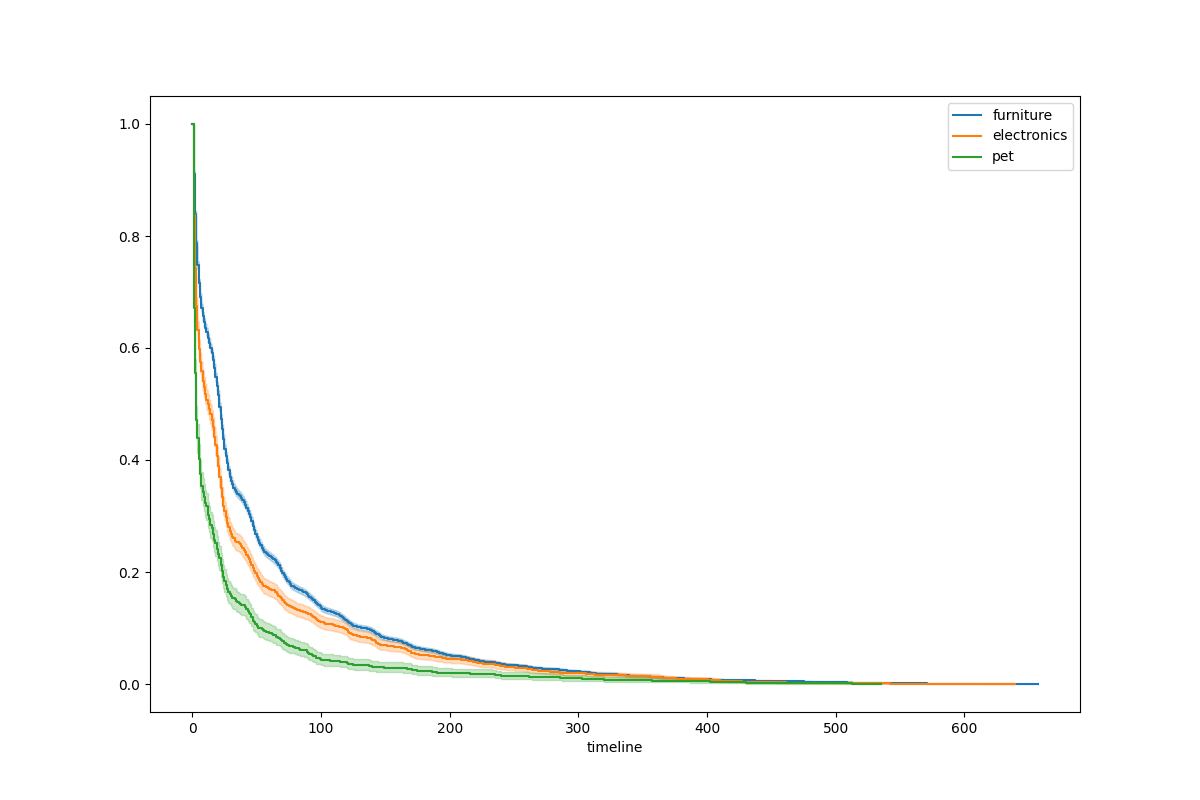

In [43]:
plt.close()
fig, ax = plt.subplots(figsize=(12,8))
for cat in ['furniture', 'electronics', 'pet']:
    subset = pdf_cats_city['hours_active'][pdf_cats_city['top_category'] == cat]
    kmf.fit(subset, label=cat)
    kmf.plot(ax=ax)

%matplot plt

### Impacts of erasure on the spatial distribution of artifacts and their representativeness of the past

To investigate the impact of these differential erasure processes on settlement archaeology-style interpretations of spatial distribution of artifacts, we took a look at the city of Boston as a case study.  Specifically, we investigated how well the posts that still survived at the end of the month corresponded to the past landscape of digital indices to objects on people's curbs. The necessary data to so was gathered below and saved to S3 for further geospatial analysis in `02_visualization.ipynb` (see Figures 5 and 8).

In [44]:
# TODO: drop "top_category" when run again (or send to later spot in notebook); `result` isn't defined until later in the notebook
erasure_df_boston = erasure_df.filter(F.col('city') == 'boston') \
                              .join(result, on='post_id') \
                              .select(['hours_active', 'time_posted', 'latitude', 'longitude', 'top_category'])

erasure_df_boston.repartition(1).write.csv('s3://craigslist-post-data/erasure_boston.csv', mode='overwrite')

non_erasure_df_boston = non_erasure_df.filter(F.col('city') == 'boston') \
                                      .join(result, on='post_id') \
                                      .select(['hours_active', 'time_posted', 'latitude', 'longitude', 'top_category'])

non_erasure_df_boston.repartition(1).write.csv('s3://craigslist-post-data/non_erasure_boston.csv', mode='overwrite')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Edits: Accretions and Erasures within Posts

Note that nearly ***35% of all posts are edited at some point after posting***. The erasure rate for these posts also seems to be a bit lower than the overall average (a little over 70% are erased -- and definitely higher number of hours active than the posts that are never edited)

In [45]:
overall.filter(overall['time_posted'] != overall['last_updated']) \
       .groupby('post_id') \
       .count() \
       .count() \
/ overall.filter(overall['time_posted'] == overall['last_updated']) \
         .groupby('post_id') \
         .count() \
         .count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.34977676937714997

In [46]:
print("Hours active (all posts, unedited)")
overall.filter(overall['time_posted'] == overall['last_updated']).groupby('post_id').count().summary().show()

print("Hours active (all posts, edited)")
overall.filter(overall['time_posted'] != overall['last_updated']).groupby('post_id').count().summary().show()

print("Edited and then erased")
erasures.filter(overall['time_posted'] != overall['last_updated']).groupby('post_id').count().summary().show()

print("Edited and never erased")
not_erased.filter(overall['time_posted'] != overall['last_updated']).groupby('post_id').count().summary().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Hours active (all posts, unedited)
+-------+-------------------+------------------+
|summary|            post_id|             count|
+-------+-------------------+------------------+
|  count|              54652|             54652|
|   mean|7.589591298153005E9| 83.24218692820025|
| stddev| 2768597.0771296895|136.85958530881484|
|    min|         7584647841|                 1|
|    25%|      7.587125659E9|                 4|
|    50%|      7.589610136E9|                23|
|    75%|      7.591836472E9|                88|
|    max|         7594394822|               672|
+-------+-------------------+------------------+

Hours active (all posts, edited)
+-------+-------------------+------------------+
|summary|            post_id|             count|
+-------+-------------------+------------------+
|  count|              19116|             19116|
|   mean|7.589248861336734E9|104.37324754132663|
| stddev|  2651237.377841564|  141.510852830941|
|    min|         7584648263|                 1|


Note additionally that posts that are edited, are usually only edited once.

In [47]:
edits_df = overall[['post_id', 'time_posted', 'last_updated', 'title', 'body_text', 'image_s3_keys']] \
               .filter(overall['time_posted'] != overall['last_updated']) \
               .dropDuplicates() \
               .persist()

n_edits_by_post = edits_df.groupby('post_id') \
                          .count()

print('% Posts edited only once')
print(n_edits_by_post.filter(F.col('count') == 1).count() / n_edits_by_post.count())

print('% Posts edited 2-5 times')
print(n_edits_by_post.filter((F.col('count') >= 2)  & (F.col('count') <= 5)).count() / n_edits_by_post.count())

print('% Posts edited more than 5 times')
print(n_edits_by_post.filter(F.col('count') > 5).count() / n_edits_by_post.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

% Posts edited only once
0.7390667503661854
% Posts edited 2-5 times
0.24649508265327474
% Posts edited more than 5 times
0.014438166980539862

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

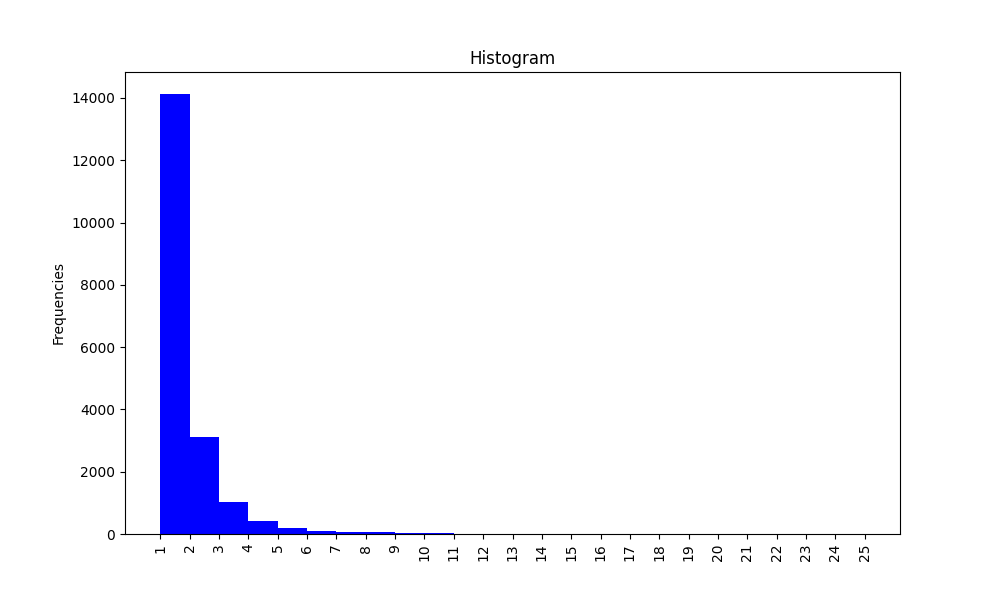

In [48]:
plt.close()
n_edits_hist_bins = n_edits_by_post.select('count') \
                            .rdd.flatMap(lambda x: x) \
                            .histogram([i for i in range(1, 26)])
plot_histogram_data(n_edits_hist_bins)
%matplot plt

### Time to edit survival

And they tend to first be ***edited within *24* hours of being posted***... (although the final edit typically takes a bit longer -- 48 hours to surpass the 60% mark)

In [ ]:
time_to_edit = edits_df.withColumn('time_to_edit_s',
                                        F.unix_timestamp('last_updated') - F.unix_timestamp('time_posted')) \
                            .withColumn('time_to_edit_h',
                                        F.col('time_to_edit_s') / 3600) \
                            .groupby('post_id') \
                            .agg(F.count('time_to_edit_h').alias('count'),
                                 F.mean('time_to_edit_h').alias('mean'),
                                 F.min('time_to_edit_h').alias('min'),
                                 F.max('time_to_edit_h').alias('max'))

In [50]:
print('% Posts edited within 1 hour of posting (first edit, followed by last edit)')
print(time_to_edit.filter(F.col('min') <= 1).count() / time_to_edit.count())
print(time_to_edit.filter(F.col('max') <= 1).count() / time_to_edit.count())

print('% Posts edited within 12 hours of posting')
print(time_to_edit.filter(F.col('min') <= 12).count() / time_to_edit.count())
print(time_to_edit.filter(F.col('max') <= 12).count() / time_to_edit.count())

print('% Posts edited within 24 hours of posting')
print(time_to_edit.filter(F.col('min') <= 24).count() / time_to_edit.count())
print(time_to_edit.filter(F.col('max') <= 24).count() / time_to_edit.count())

print('% Posts edited within 48 hours of posting')
print(time_to_edit.filter(F.col('min') <= 48).count() / time_to_edit.count())
print(time_to_edit.filter(F.col('max') <= 48).count() / time_to_edit.count())

print('% Posts edited within 1 week of posting')
print(time_to_edit.filter(F.col('min') <= 7*24).count() / time_to_edit.count())
print(time_to_edit.filter(F.col('max') <= 7*24).count() / time_to_edit.count())

print('% Posts edited within 14 days of posting')
print(time_to_edit.filter(F.col('min') <= 14*24).count() / time_to_edit.count())
print(time_to_edit.filter(F.col('max') <= 14*24).count() / time_to_edit.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

% Posts edited within 1 hour of posting (first edit, followed by last edit)
0.40081607030759575
0.3146055660179954
% Posts edited within 12 hours of posting
0.5625653902490061
0.4732684662063193
% Posts edited within 24 hours of posting
0.6418183720443608
0.5556078677547605
% Posts edited within 48 hours of posting
0.7094580456162377
0.6279033270558694
% Posts edited within 1 week of posting
0.9207993304038502
0.8507009834693451
% Posts edited within 14 days of posting
0.9795459301109019
0.9485247959824231

If we visualize only the first 72 hours, it is clear that the vast majority of the posts are only edited within a short period after posting (although there are regularly spikes at the 24 hour mark -- i.e. a user checking and updated their post a day later):

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

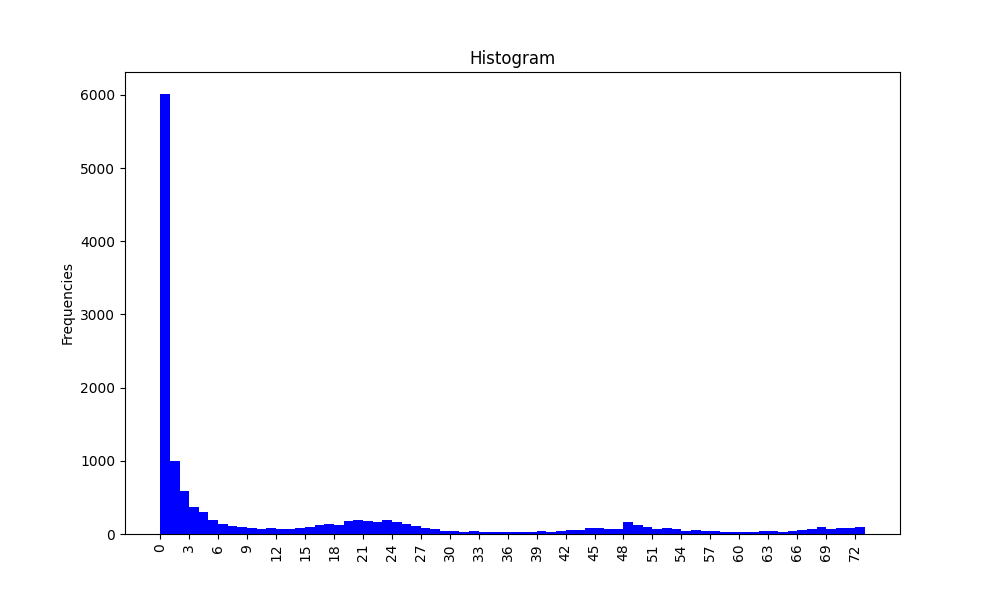

In [51]:
plt.close()
time_to_edit_hist_bins = time_to_edit.select('max') \
                                     .rdd.flatMap(lambda x: x) \
                                     .histogram(hourly_bin_boundaries)

# export for plotting outside of PySpark environment
to_plot['fig9'] = time_to_edit_hist_bins

plot_histogram_data((time_to_edit_hist_bins[0][:(3 * 24 + 1)], time_to_edit_hist_bins[1][:(3 * 24 + 1)]))
plt.xticks(np.arange(0, 3 * 24 + 1, 3), labels=np.arange(0, 3 * 24 + 1, 3))
%matplot plt

The overall time-to-edit survival curve is less steep than is the time-erasure curve that we observed above:

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

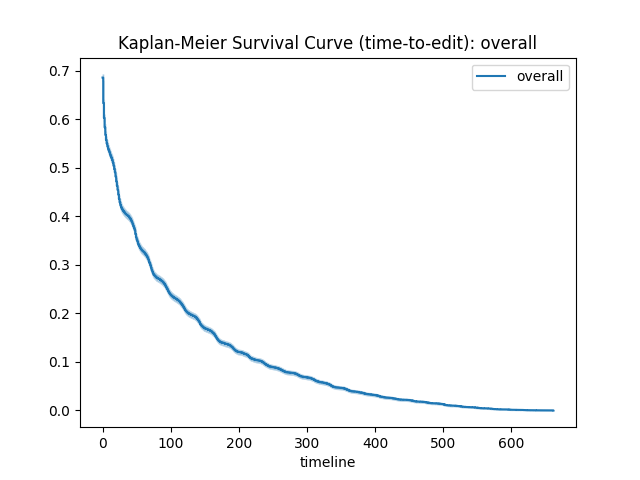

In [52]:
durations_overall = np.repeat(time_to_edit_hist_bins[0][:-1], time_to_edit_hist_bins[1])

kmf.fit(durations_overall, label='overall')

plt.close()
kmf.plot(title='Kaplan-Meier Survival Curve (time-to-edit): {}'.format('overall'))
%matplot plt

We do, however, see different time-to-edit probabilities by region, producing different in-post palimpsests to interpret.

In [53]:
pdf_cats_city = time_to_edit.join(overall_cats_df, on='post_id').select([F.col('max').alias('duration'), 'city', 'top_category']).toPandas()
pdf_cats_city.loc[:, 'region'] = pdf_cats_city.city.apply(lambda city: [r for r, c in regions.items() if city in c][0])
pdf_cats_city_non_other = pdf_cats_city[pdf_cats_city['top_category'] != 'other']

# export for plotting outside of PySpark environment
to_plot['fig11_12'] = pdf_cats_city.to_dict()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
log_rank = pairwise_logrank_test(pdf_cats_city['duration'], pdf_cats_city['region'])
log_rank.print_summary()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                     test_statistic      p  -log2(p)
midwest   northeast            7.17   0.01      7.08
          south               17.05 <0.005     14.74
          west                 0.39   0.53      0.91
northeast south               65.97 <0.005     50.96
          west                29.75 <0.005     24.28
south     west                27.41 <0.005     22.53

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

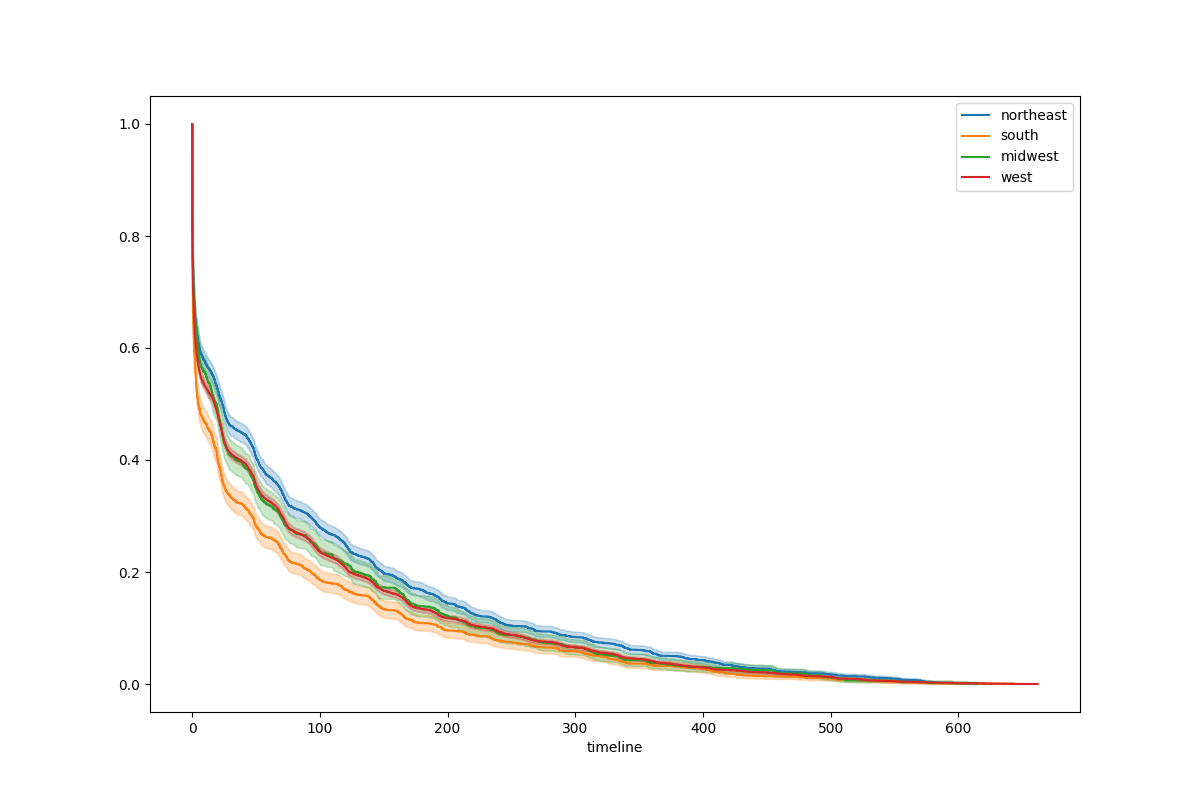

In [55]:
plt.close()
fig, ax = plt.subplots(figsize=(12,8))
for r in regions.keys():
    region_mask = pdf_cats_city['region'] == r
    kmf.fit(pdf_cats_city[region_mask]['duration'], label=r)
    kmf.plot(ax=ax)

%matplot plt

In [56]:
log_rank = pairwise_logrank_test(pdf_cats_city_non_other['duration'], pdf_cats_city_non_other['top_category'])
log_rank.print_summary()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                                         test_statistic      p  -log2(p)
arts_crafts         auto_garage                    7.91 <0.005      7.67
                    books_and_magazines            0.01   0.93      0.10
                    children                       3.57   0.06      4.09
                    clothing                       0.78   0.38      1.40
                    electronics                    2.40   0.12      3.04
                    fire_wood                     11.67 <0.005     10.62
                    fitness                       11.46 <0.005     10.46
                    furniture                     10.92 <0.005     10.04
                    kitchen                        5.23   0.02      5.50
                    pet                           27.49 <0.005     22.60
                    raw_material  

Note that time-to-edit is a bit different by item than time-to-erasure -- furniture, for instance, tends to be edited quicker within posts, but removed slower at a post-level than electronics.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

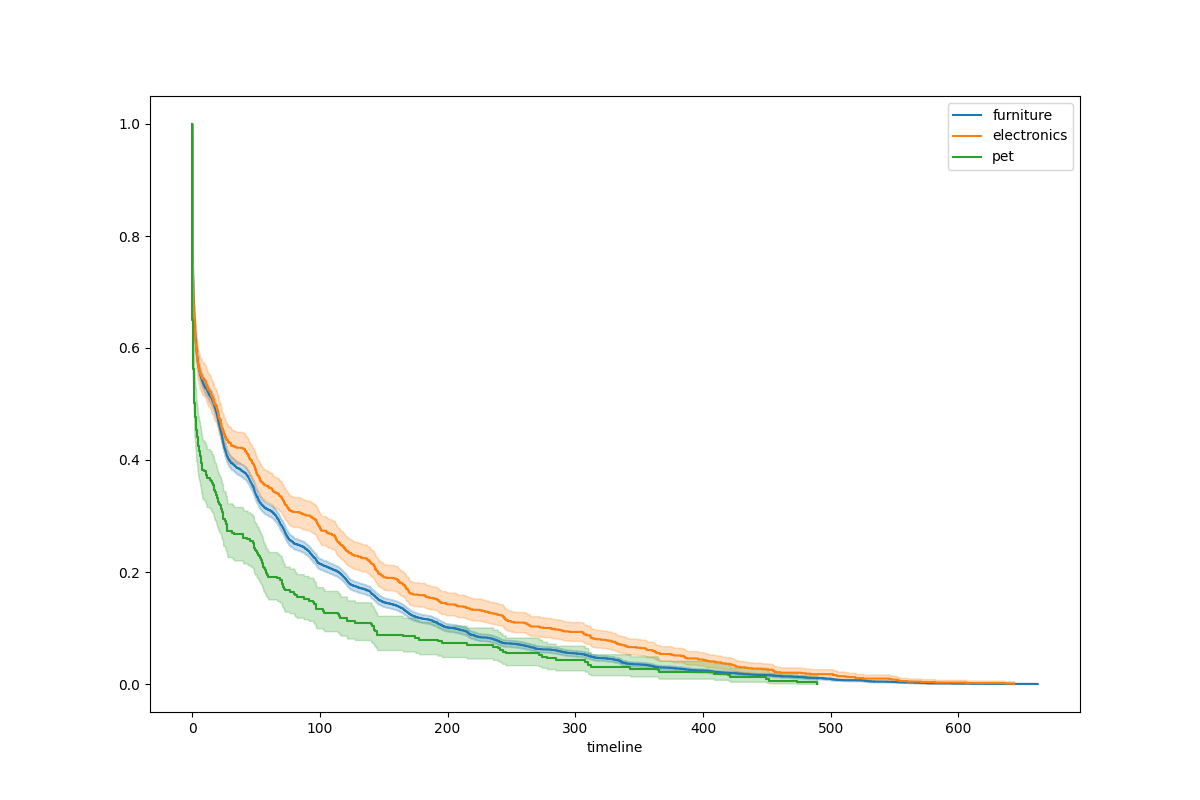

In [57]:
plt.close()
fig, ax = plt.subplots(figsize=(12,8))
for cat in categories.keys():
    if cat in {'furniture', 'electronics', 'pet'}:
        subset = pdf_cats_city['duration'][pdf_cats_city['top_category'] == cat]
        kmf.fit(subset, label=cat)
        kmf.plot(ax=ax)

%matplot plt

### Text edits: Titles and Body Text

To interpret the exact nature of these edits (i.e. are they accretionary? mostly erasures?), we computed the Levenshtein distance between the title and body text for each post that had been edited. Levenshtein distance measures the minimum number of edits that need to be performed in order to change one string of text into another (via character substitutions, insertions, and deletions). In order to identify the net impact of these edits (i.e. did the overall text grow or shrink?), we also computed the difference in length between the previous version of a text and its current version. In this way, we could identify whether an edit was mostly centered on erasure or accretion, as well as the magnitude of the edit overall (via Levenshtein distance).

In [58]:
window = Window.partitionBy('post_id').orderBy('last_updated')

edits_lag_df = overall[['post_id', 'time_posted', 'last_updated', 'title', 'body_text', 'image_s3_keys']] \
                   .dropDuplicates(['post_id', 'time_posted', 'last_updated']) \
                   .withColumn('lag_title', F.lag(F.col('title'), 1).over(window)) \
                   .withColumn('lag_body_text', F.lag(F.col('body_text'), 1).over(window)) \
                   .withColumn('lag_image_s3_keys', F.lag(F.col('image_s3_keys'), 1).over(window)) \
                   .filter((F.col('time_posted') != F.col('last_updated')) & F.col('lag_title').isNotNull()) \
                   .persist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In general, we can see that the average edit distance is fairly small (i.e. edits are generally not very extreme; users are tweaking only a few characters each time):

In [59]:
lev_edits = edits_lag_df.withColumn('levenshtein_title', F.levenshtein(F.col('title'), F.col('lag_title'))) \
                        .withColumn('levenshtein_body_text', F.levenshtein(F.col('body_text'), F.col('lag_body_text'))) \
                        .withColumn('title_diff', F.length('title') - F.length('lag_title')) \
                        .withColumn('body_diff', F.length('body_text') - F.length('lag_body_text')) \
                        .withColumn('accretion', (F.col('title_diff') > 0) | (F.col('body_diff') > 0)) \
                        .withColumn('erasure', (F.col('title_diff') < 0) | (F.col('body_diff') < 0)) \

lev_edits.select('levenshtein_title', 'levenshtein_body_text', 'title_diff', 'body_diff') \
         .summary() \
         .show()

lev_edits.select('levenshtein_title', 'levenshtein_body_text') \
         .where((F.col('levenshtein_title') >= 1)) \
         .summary() \
         .show()

lev_edits.select('levenshtein_title', 'levenshtein_body_text') \
         .where((F.col('levenshtein_body_text') >= 1)) \
         .summary() \
         .show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+---------------------+-----------------+-----------------+
|summary|levenshtein_title|levenshtein_body_text|       title_diff|        body_diff|
+-------+-----------------+---------------------+-----------------+-----------------+
|  count|            17918|                17914|            17918|            17914|
|   mean|3.113126465007255|    29.70643072457296|0.510548052237973| 6.32628112091102|
| stddev|7.631285473656041|    70.91455152503617|6.566431052498106|66.47665990405629|
|    min|                0|                    0|              -52|            -1931|
|    25%|                0|                    0|                0|                0|
|    50%|                0|                    0|                0|                0|
|    75%|                0|                   31|                0|                0|
|    max|               62|                 1931|               61|             1040|
+-------+-----------------+---------------------+-----

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

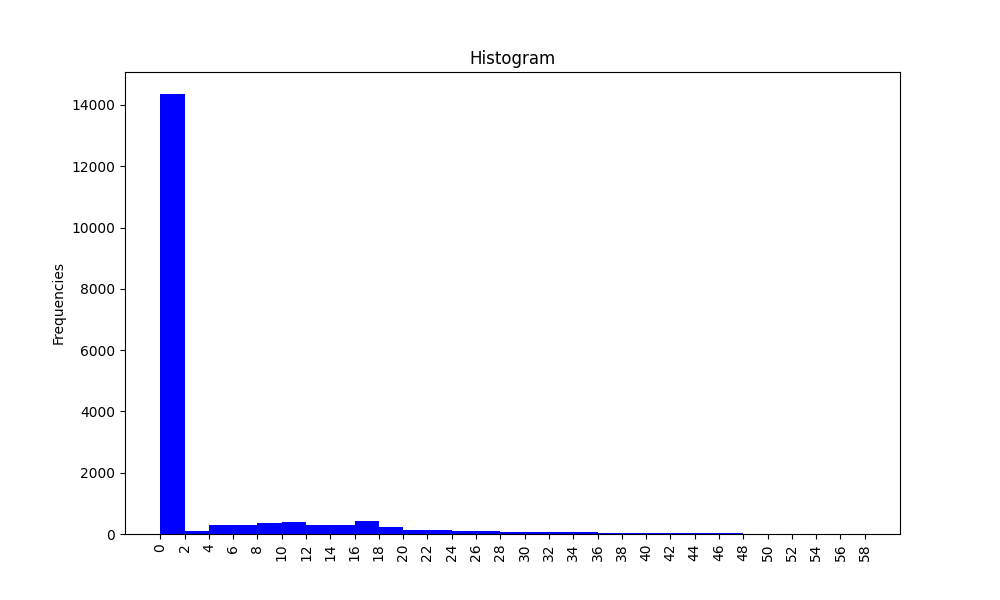

In [62]:
plt.close() # Note that most edits do not involve title edits -- hence so many 0s.
lev_title_hist_bins = lev_edits.select('levenshtein_title') \
                            .rdd.flatMap(lambda x: x) \
                            .histogram([i for i in range(0, 60, 2)])
plot_histogram_data(lev_title_hist_bins)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

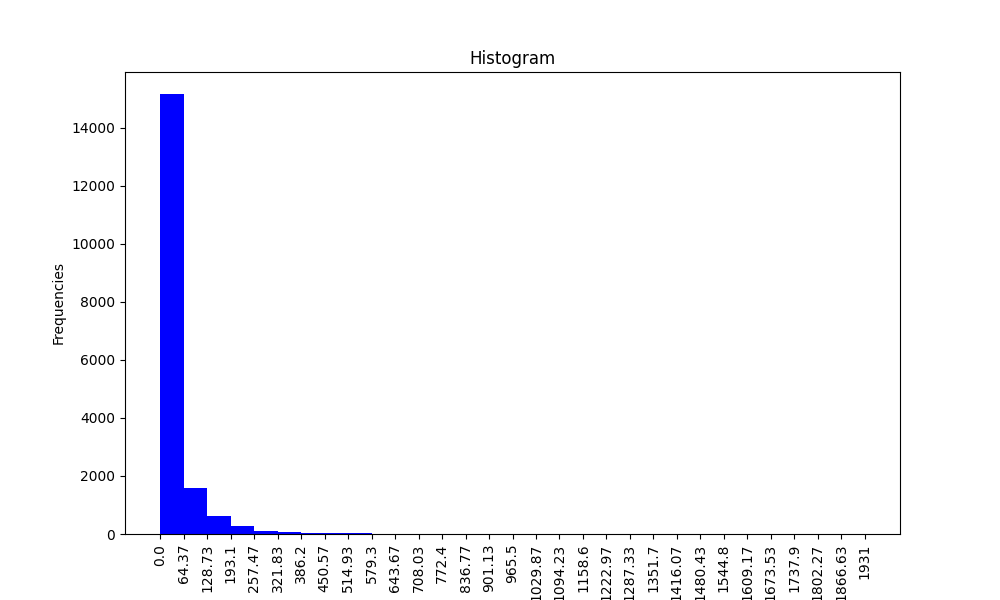

In [63]:
plt.close()
lev_body_hist_bins = lev_edits.select('levenshtein_body_text') \
                            .rdd.flatMap(lambda x: x) \
                            .histogram(30)
plot_histogram_data(lev_body_hist_bins)
%matplot plt

A majority of edits are accretionary, with only ~1/3 involving net erasure. A qualitative analysis of the edits in one of the posts reveals that these accretionary edits tend to involve providing more context and clarification for a post.

In [78]:
print('erasure and accretion: ', lev_edits.filter(F.col('accretion') & F.col('erasure')).count())
print('accretion and not erasure: ', lev_edits.filter(F.col('accretion') & ~F.col('erasure')).count())
print('erasure and not accretion: ', lev_edits.filter(~F.col('accretion') & F.col('erasure')).count())

print('total accretion: ', lev_edits.filter('accretion').count())
print('total erasure: ',lev_edits.filter('erasure').count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

erasure and accretion:  607
accretion and not erasure:  5048
erasure and not accretion:  2276
total accretion:  5657
total erasure:  2883

Note that there are some small differences in the ratio between accretion and erasure by type of object listed in a post, although most categories with larger sample sizes are hovering 2:1 accretions to erasure.

In [66]:
lev_edits_cat = lev_edits.join(result[['post_id', 'top_category']], on='post_id').persist()

lev_acc_cnt_by_cat = lev_edits_cat.filter('accretion') \
                                  .groupBy('top_category') \
                                  .count() \
                                  .withColumnRenamed('count', 'accretion')

lev_eras_cnt_by_cat = lev_edits_cat.filter('erasure') \
                                   .groupBy('top_category') \
                                   .count() \
                                   .withColumnRenamed('count', 'erasure')

lev_acc_cnt_by_cat.join(lev_eras_cnt_by_cat, on='top_category') \
                  .withColumn('accretion_to_erasure', F.col('accretion') / F.col('erasure')) \
                  .show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+---------+-------+--------------------+
|       top_category|accretion|erasure|accretion_to_erasure|
+-------------------+---------+-------+--------------------+
|          fire_wood|       24|      9|  2.6666666666666665|
|          furniture|     2184|   1311|   1.665903890160183|
|        electronics|      294|    131|  2.2442748091603053|
|        arts_crafts|       35|     12|  2.9166666666666665|
|           children|      378|    205|  1.8439024390243903|
|books_and_magazines|       35|     14|                 2.5|
|            kitchen|      512|    271|  1.8892988929889298|
|        auto_garage|     1075|    423|   2.541371158392435|
|                pet|       63|     18|                 3.5|
|              other|      226|    104|   2.173076923076923|
|       raw_material|      492|    208|  2.3653846153846154|
|           clothing|       67|     33|  2.0303030303030303|
| shipping_materials|      202|    105|  1.9238095238095239|
|            fitness|   

Pulling out one post for qualitative analysis (discussed in the article "Results" section), we can see text insertions that index the changing number of items that are available for removal over time, as well as add clarification when objects have been listed for a long time and the user attempts to persuade others to take the item(s). These edits are paradigmatic of the text edits most commonly encountered in this dataset.

In [68]:
data.filter(F.col('post_id') == '7584840111') \
    .dropDuplicates(['body_text']) \
    .sort('last_updated') \
    .select('last_updated', 'body_text') \
    .show(truncate=150)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|       last_updated|                                                                                                                                             body_text|
+-------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|2023-02-01 17:18:31|8 high-top bar tables (44" tall)  --Square tables (5 available, 24" x 30") --Round tables (2 available, 3' diameter)  20 high-top bar chairs availa...|
|2023-02-01 22:09:00|5 square high top bar tables (44'' tall, 24" x 30")  12 high-top bar chairs available (seat height 30")  4 short bar/restaurant tables and chairs  ...|
|2023-02-02 15:48:38|5 square high top bar tables (44'' tall, 24" x 30")  4 short bar/restaurant tables and 10 short chairs  As-is, som

### Image edits: removing and adding new images to a post

For images, each image has a unique identifier, so we can assess which exact images were erased or added over the lifetime of a post.

In [ ]:
img_edits = lev_edits_cat.select('post_id',
                                 'top_category',
                                 'lag_image_s3_keys', 
                                 'image_s3_keys',
                                 F.array_except(F.col('image_s3_keys'), F.col('lag_image_s3_keys')).alias('accretion'),
                                 F.array_except(F.col('lag_image_s3_keys'), F.col('image_s3_keys')).alias('erasure')) \
                         .select('*',
                                 F.when(F.array_contains(F.col('erasure'), '[]'), F.size(F.col('erasure')) - 1) \
                                  .otherwise(F.size(F.col('erasure'))) \
                                  .alias('erasure_count'),
                                 F.when(F.array_contains(F.col('accretion'), '[]'), F.size(F.col('accretion')) - 1) \
                                  .otherwise(F.size(F.col('accretion'))) \
                                  .alias('accretion_count')
                          ) \
                    .filter((F.col('erasure_count') > 0) | (F.col('accretion_count') > 0))

Note that edits to the images occur in less than 20% of all edits. Furthermore, less than 25% of the users who made edits made image edits (i.e. text edits are more prominent and image edits are fairly rare).

In [70]:
print('overall image edits to overall edits: ', img_edits.count() / lev_edits.count())
print('image edits to overall edits by user: ', img_edits.groupby('post_id').count().count() / lev_edits.groupby('post_id').count().count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

overall image edits to overall edits:  0.19187409309074674
image edits to overall edits by user:  0.24435116549075644

Of the image edits that were made, most of them involved both accretion and erasure of images, although a portion involved only erasure (less than 10%) or only accretion (around 20%). Looking at the histograms below, we can see as well that the number of images erased or added is typically in the 1-5 image range in a given editing event.

In [80]:
print('Erasure and no accretion count:', img_edits.filter((F.col('erasure_count') > 0) & ~(F.col('accretion_count') > 0)).count())
print('Accretion and no erasure:', img_edits.filter(~(F.col('erasure_count') > 0) & (F.col('accretion_count') > 0)).count())
print('Accretion and erasure:',img_edits.filter((F.col('accretion_count') > 0) & (F.col('erasure_count') > 0)).count())
print('Total image edits (accretion or erasure):', img_edits.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Erasure and no accretion count: 228
Accretion and no erasure: 619
Accretion and erasure: 2591
Total image edits (accretion or erasure): 3438

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

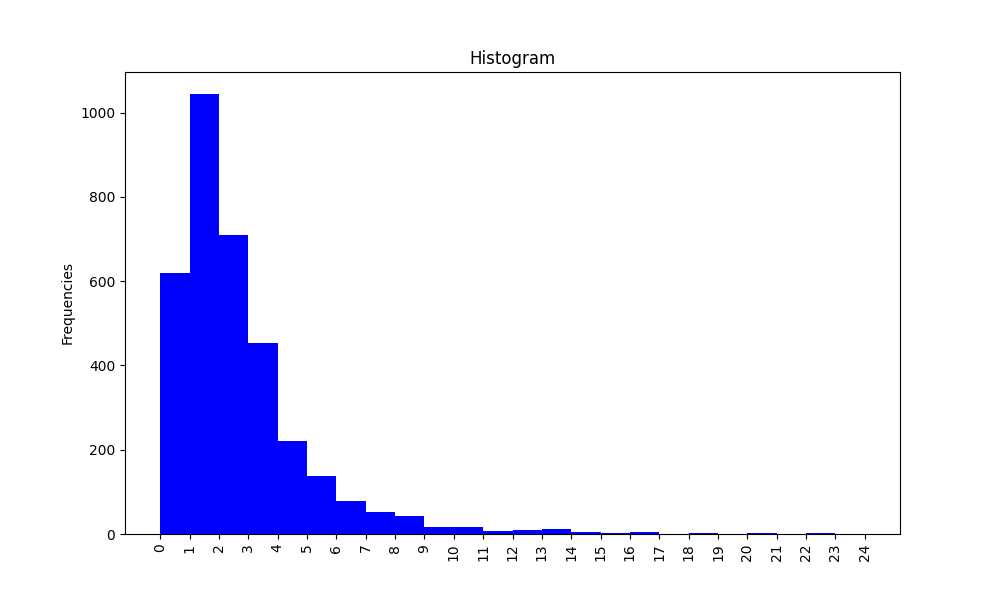

In [72]:
plt.close()
image_erasure_hist_bins = img_edits.select('erasure_count') \
                                   .rdd.flatMap(lambda x: x) \
                                   .histogram([i for i in range(25)])
plot_histogram_data(image_erasure_hist_bins)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

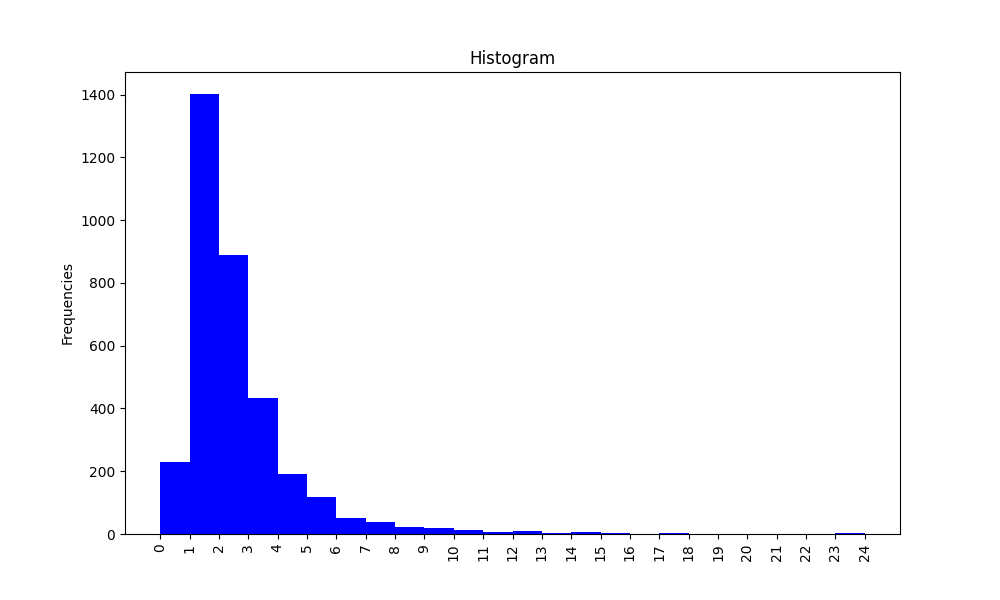

In [73]:
plt.close()
image_accretion_hist_bins = img_edits.select('accretion_count') \
                                     .rdd.flatMap(lambda x: x) \
                                     .histogram([i for i in range(25)])
plot_histogram_data(image_accretion_hist_bins)
%matplot plt

Across the categories, there is a tendency to add and remove images in roughly the same proportion (although there are some divergences in "arts and crafts" an "clothing"). We do not see the asymmetry that we saw in text edits. This might be a function of how updating a photo involves uploading a new, modified version of the original photo (with a different ID number) and then deleting the original photo (see the qualitative example in the article text based on the image updates listed below). The majority of photo edits might then involve such "update" operations.

In [74]:
img_edits.groupBy('top_category') \
         .agg(F.sum(F.col('accretion_count')).alias('accretion'),
              F.sum(F.col('erasure_count')).alias('erasure')) \
         .withColumn('accretion_to_erasure', F.col('accretion') / F.col('erasure')) \
         .show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+---------+-------+--------------------+
|       top_category|accretion|erasure|accretion_to_erasure|
+-------------------+---------+-------+--------------------+
|          fire_wood|       50|     44|  1.1363636363636365|
|          furniture|     3113|   3578|  0.8700391280044718|
|        electronics|      260|    299|  0.8695652173913043|
|        arts_crafts|       59|     33|  1.7878787878787878|
|           children|      444|    479|  0.9269311064718163|
|books_and_magazines|       44|     48|  0.9166666666666666|
|            kitchen|      669|    677|  0.9881831610044313|
|        auto_garage|     1108|   1006|  1.1013916500994037|
|                pet|       58|     48|  1.2083333333333333|
|              other|      341|    324|  1.0524691358024691|
|       raw_material|      771|    641|   1.202808112324493|
|           clothing|       86|    142|  0.6056338028169014|
| shipping_materials|      236|    188|  1.2553191489361701|
|            fitness|   

Qualitative interpretation of image changes:

In [75]:
data.filter(F.col('post_id') == '7590768655') \
    .dropDuplicates(['body_text']) \
    .sort('last_updated') \
    .select('last_updated', 'image_s3_keys') \
    .show(truncate=50)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------------------------------------------------+
|       last_updated|                                     image_s3_keys|
+-------------------+--------------------------------------------------+
|2023-02-18 18:59:56| [['images/00n0n_lwJUSz2t3zw_0CI0t2_600x450.jpg']]|
|2023-02-18 20:58:01| [['images/01717_lVo4zkJpabq_0CI0t3_600x450.jpg']]|
|2023-02-19 20:59:55| [['images/00u0u_5TygkvkvWG8_0CI0t3_600x450.jpg']]|
|2023-02-19 23:20:17|[['images/00p0p_hURsdsUVkVC_0CI0t2_600x450.jpg'...|
+-------------------+--------------------------------------------------+

In the case of this post, we start with an image that looks like so (at 2023-02-18 18:59:56):

![](data/images/00n0n_lwJUSz2t3zw_0CI0t2_600x450.jpg)

As items are taken from the curb, they are crossed out at 2023-02-18 20:58:01 ...

![](data/images/01717_lVo4zkJpabq_0CI0t3_600x450.jpg)

... and at 2023-02-19 20:59:55:

![](data/images/00u0u_5TygkvkvWG8_0CI0t3_600x450.jpg)

Finally (at 2023-02-19 23:20:17), the user adds several new photos, with new items added to the curb as well that weren't there at the outset.

![](data/images/00g0g_fbHTEiHT5Xu_0CI0t2_600x450.jpg)

All of this is to say that even within a given post, there is a fair amount of activity -- erasure and accretion -- which all play a role in digital formation processes. Sometimes, these are to add clarifying language, to indicate that an object is no longer there (either via image, etc.), or to otherwise update the digital indexical link to the physical world.

We have now collected all of the aggregate data `survival_data.json` we need in order to produce the figures in the article body and can write this to S3 (copied to the [`\data`](./data/) subdirectory of this current directory). We can now proceed to [`02_visualization.ipynb`](./02_visualization.ipynb) to replicate the figures in the article body.

In [ ]:
# Write all collected aggregate data to S3 as JSON for use in 02_visualization.ipynb
s3_client.put_object(Body=json.dumps(to_plot), Bucket='craigslist-post-data', Key='survival_data.json')